# Imports, device and seeding

In [1]:
# --- Standard libs ---
import os
import math
import random
from dataclasses import dataclass
from typing import Dict, Any
import pickle

# --- Scientific stack ---
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- ACORL and RL ---
from acorl.envs.seeker.seeker import SeekerEnv, SeekerEnvConfig

# --- Own Code ---
from MCTS import MCTSPlanner
from network import SeekerAlphaZeroNet
from utils import (
    ReplayBufferHybrid,
    collect_one_episode_hybrid,
    train_step_mle,
    train_step_mcts_distill,
    train_step_hybrid,
    run_eval_episodes,
    run_debug_eval_episode,
)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# --- Reproducibility ---
def set_global_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


SEED = 42
set_global_seeds(SEED)

Using device: cpu


# Config

## baseline config
### Comments are explaining what each parameter does in general, but also mixed with comments that explain behavious of this specific configuration

In [2]:
@dataclass
class Config:
    # ========================
    # Environment
    # ========================
    max_episode_steps: int = 200

    # ========================
    # MCTS core
    # ========================
    num_simulations: int = 200    # Number of MCTS simulations per real environment step
    cpuct: float = 1.5            # Exploration vs exploitation tradeoff in PUCT; Higher -> more exploration guided by policy prior
    gamma: float = 0.99           # Discount factor for return backup in MCTS
    max_depth: int = 64           # Safety cap on tree depth during a simulation

    # For root action selection / Action sampling temperature at root
    # >1.0 = more stochastic, 1.0 = proportional to visits, ~0 = greedy
    temperature: float = 1.0

    # ========================
    # Progressive Widening
    # ========================
    pw_k: float = 2.0
    # Controls how many actions are allowed per node:
    #   K_max = pw_k * N(s)^pw_alpha
    pw_alpha: float = 0.5
    # Growth rate of branching factor
    # 0.5 is common; smaller = more conservative expansion

    # ========================
    # Action sampling (baseline, non-fancy, but no duplicates)
    # ========================
    # --- Uniform warmstart ---
    # No uniform warmstart, no diversity scoring
    K_uniform_per_node: int = 8
    # First K children per node are sampled uniformly in [-1,1]^2
    # Set to 0 to disable
    warmstart_iters: int = 20
    # Number of *training iterations* during which ALL nodes use uniform sampling
    # 0 disables global warmstart; use this if you want uniform sampling only early in training

    # --- Novelty reject (hard deduplication) ---
    # Deduplicate actions (keep this ON to satisfy “no duplicate actions”)
    novelty_eps: float = 1e-3      # small but > 0
    # Minimum distance between actions to be considered "new"
    # In [-1,1]^2, values around 0.05–0.15 are reasonable
    # Set <=0 to disable
    novelty_metric: str = "l2"
    # Distance metric for novelty check:
    # "linf" = max(|dx|, |dy|)  (good for box action spaces)
    # "l2"   = Euclidean distance

    # --- Diversity scoring (soft repulsion) ---
    # Disable candidate scoring / diversity
    num_candidates: int = 1
    # Number of candidate actions sampled before choosing the best
    # <=1 disables diversity scoring
    diversity_lambda: float = 0.0
    # Strength of diversity penalty
    # Higher -> stronger push away from already-sampled actions
    # Set <=0 to disable
    diversity_sigma: float = 0.25  # unused
    # Length scale for diversity penalty
    # Roughly: how far actions must be before they stop "repelling" each other
    policy_beta: float = 1.0       # unused
    # Weight of policy log-probability in candidate scoring
    # Higher -> follow policy more closely
    # Lower -> prioritize diversity more

    # --- Resampling control ---
    max_resample_attempts: int = 16
    # How many times expansion may retry to find a novel action
    # If all fail, expansion is declined and MCTS falls back to selection
    
    # ========================
    # Training
    # ========================
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-4
    train_steps_per_iter: int = 200    # Gradient updates per outer iteration

    # (Only used by our baseline loss function)
    value_loss_weight: float = 1.0
    policy_loss_weight: float = 1.0  # applies to mu/log_std regression

    # ========================
    # Data collection
    # ========================
    episodes_per_iter: int = 10     # Number of real env episodes collected per training iteration
    replay_buffer_capacity: int = 50_000

    # ========================
    # Logging / evaluation
    # ========================
    eval_every: int = 5
    eval_episodes: int = 10   # use 10 fixed seeds for smoother eval curves


cfg = Config()


## Sanity test

In [3]:
from pprint import pprint
pprint(cfg)

Config(max_episode_steps=200,
       num_simulations=200,
       cpuct=1.5,
       gamma=0.99,
       max_depth=64,
       temperature=1.0,
       pw_k=2.0,
       pw_alpha=0.5,
       K_uniform_per_node=8,
       warmstart_iters=20,
       novelty_eps=0.001,
       novelty_metric='l2',
       num_candidates=1,
       diversity_lambda=0.0,
       diversity_sigma=0.25,
       policy_beta=1.0,
       max_resample_attempts=16,
       batch_size=128,
       learning_rate=0.0003,
       weight_decay=0.0001,
       train_steps_per_iter=200,
       value_loss_weight=1.0,
       policy_loss_weight=1.0,
       episodes_per_iter=10,
       replay_buffer_capacity=50000,
       eval_every=5,
       eval_episodes=10)


# Create env_real, env_sim, dims (for network), and step_fn (for MCTSPlanner)

In [4]:
EVAL_SEEDS = list(range(1000, 1000 + cfg.eval_episodes))  # fixed "validation set"

# --- Env config ---
env_config = SeekerEnvConfig(randomize=True, num_obstacles=1)

# --- Real environment for rollouts / data collection ---
env_real = SeekerEnv(**env_config.model_dump(exclude={"id"}))
obs0, info0 = env_real.reset()

obs_dim = env_real.observation_space.shape[0]
action_dim = env_real.action_space.shape[0]

print("obs_dim:", obs_dim, "action_dim:", action_dim)
print("action_space:", env_real.action_space)

# --- Simulation environment for MCTS step_fn ---
env_sim = SeekerEnv(**env_config.model_dump(exclude={"id"}))

# --- evaluation environment for evaluation during training ---
env_eval = SeekerEnv(**env_config.model_dump(exclude={"id"}))


def set_env_state_from_obs(sim_env: SeekerEnv, obs: np.ndarray):
    """
    Overwrite SeekerEnv internal state to match the flat observation vector.

    obs layout (from your old notebook):
      [agent_x, agent_y, goal_x, goal_y, (obs_x, obs_y, obs_r)*N]
    """
    obs = np.asarray(obs, dtype=sim_env._dtype)

    # agent and goal
    sim_env._agent_position = obs[0:2].copy()
    sim_env._goal_position = obs[2:4].copy()

    # obstacles
    obstacles = obs[4:].reshape(-1, 3)
    sim_env._obstacle_position = obstacles[:, 0:2].copy()
    sim_env._obstacle_radius = obstacles[:, 2].copy()

def step_fn(state: np.ndarray, action: np.ndarray):
    """
    MCTS transition function: set env_sim to `state`, take `action`, return next_state/reward/done/info.
    Returns: next_state, reward, done, info  (matching MCTSPlanner expectations)
    """
    set_env_state_from_obs(env_sim, state)

    action = np.asarray(action, dtype=env_sim._dtype)
    next_obs, reward, terminated, truncated, info = env_sim.step(action)
    done = bool(terminated or truncated)

    return next_obs, float(reward), done, info

obs_dim: 7 action_dim: 2
action_space: Box(-1.0, 1.0, (2,), float64)


# Instantiate neural network and optimizer

In [5]:
# --- Network ---
net = SeekerAlphaZeroNet(obs_dim=obs_dim, action_dim=action_dim).to(device)

# Optional: print one forward pass sanity
obs_t = torch.from_numpy(obs0).float().unsqueeze(0).to(device)
with torch.no_grad():
    mu_t, log_std_t, v_t = net(obs_t)

print("mu:", mu_t.cpu().numpy())
print("log_std:", log_std_t.cpu().numpy())
print("v:", v_t.item())

# --- Optimizer (we'll use later) ---
optimizer = optim.AdamW(net.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

mu: [[-0.26337135 -0.13172348]]
log_std: [[ 0.45294833 -0.14332369]]
v: 0.02973608300089836


# Instantiate MCTSPlanner

In [6]:
planner = MCTSPlanner(
    net=net,
    device=str(device),
    step_fn=step_fn,
    num_simulations=cfg.num_simulations,
    cpuct=cfg.cpuct,
    gamma=cfg.gamma,
    pw_k=cfg.pw_k,
    pw_alpha=cfg.pw_alpha,
    max_depth=cfg.max_depth,
    temperature=cfg.temperature,
    rng=np.random.default_rng(SEED),
    
    K_uniform_per_node=cfg.K_uniform_per_node,
    warmstart_iters=cfg.warmstart_iters,
    novelty_eps=cfg.novelty_eps,
    novelty_metric=cfg.novelty_metric,
    num_candidates=cfg.num_candidates,
    diversity_lambda=cfg.diversity_lambda,
    diversity_sigma=cfg.diversity_sigma,
    policy_beta=cfg.policy_beta,
    max_resample_attempts=cfg.max_resample_attempts,
)

# Smoke test: one MCTS search, inspect root, pick action, step env_real

In [7]:
# Reset real env
obs, info = env_real.reset()

# Run one MCTS search from the current observation
root = planner.search(obs)

print("Root visit count N:", root.N)
print("Root children K:", len(root.children))

# Show a few children stats
for i, ch in enumerate(root.children[:5]):
    print(
        f"[{i}] N_sa={ch.N_sa:4d}  Q_sa={ch.Q_sa:+.4f}  "
        f"P_raw={ch.P_sa_raw:.3e}  P={ch.P_sa:.3f}  action={ch.action}"
    )

# Pick an action from MCTS policy (training=True samples from visit counts)
action = planner.act(root, training=True)
print("Chosen action:", action)

# Step the real environment once
next_obs, reward, terminated, truncated, info = env_real.step(action)
done = bool(terminated or truncated)

print("Step result -> reward:", reward, "done:", done)
print("Obs delta L2:", np.linalg.norm(next_obs - obs))


Root visit count N: 200
Root children K: 29
[0] N_sa=   5  Q_sa=-21.3346  P_raw=1.123e-01  P=0.044  action=[ 0.5479121  -0.12224312]
[1] N_sa=   3  Q_sa=-33.9120  P_raw=8.752e-02  P=0.035  action=[0.71719587 0.39473605]
[2] N_sa=   4  Q_sa=-2.7142  P_raw=4.341e-02  P=0.017  action=[-0.8116453  0.9512447]
[3] N_sa=   6  Q_sa=-17.9681  P_raw=7.721e-02  P=0.031  action=[0.5222794 0.5721286]
[4] N_sa=  11  Q_sa=-2.6866  P_raw=5.583e-02  P=0.022  action=[-0.25840396  0.85353   ]
Chosen action: [-0.06088838 -0.6210573 ]
Step result -> reward: -0.9035175975254326 done: False
Obs delta L2: 0.6240348783470926


In [8]:
# Show all children stats
for i, ch in enumerate(root.children):
    print(
        f"[{i}] N_sa={ch.N_sa:4d}  Q_sa={ch.Q_sa:+.4f}  "
        f"P_raw={ch.P_sa_raw:.3e}  P={ch.P_sa:.3f}  action={ch.action}"
    )

actions = np.stack([ch.action for ch in root.children], axis=0)
print("unique rows:", np.unique(actions, axis=0).shape[0], " / ", actions.shape[0])

[0] N_sa=   5  Q_sa=-21.3346  P_raw=1.123e-01  P=0.044  action=[ 0.5479121  -0.12224312]
[1] N_sa=   3  Q_sa=-33.9120  P_raw=8.752e-02  P=0.035  action=[0.71719587 0.39473605]
[2] N_sa=   4  Q_sa=-2.7142  P_raw=4.341e-02  P=0.017  action=[-0.8116453  0.9512447]
[3] N_sa=   6  Q_sa=-17.9681  P_raw=7.721e-02  P=0.031  action=[0.5222794 0.5721286]
[4] N_sa=  11  Q_sa=-2.6866  P_raw=5.583e-02  P=0.022  action=[-0.25840396  0.85353   ]
[5] N_sa=  21  Q_sa=-2.6812  P_raw=1.026e-01  P=0.041  action=[-0.1131716 -0.5455226]
[6] N_sa=   2  Q_sa=-50.0328  P_raw=1.100e-01  P=0.044  action=[ 0.5161755  -0.29094806]
[7] N_sa=   6  Q_sa=-18.4197  P_raw=7.088e-02  P=0.028  action=[-0.066558  -0.9123925]
[8] N_sa=  17  Q_sa=-8.2274  P_raw=9.686e-02  P=0.038  action=[-0.06088838 -0.6210573 ]
[9] N_sa=   2  Q_sa=-50.1219  P_raw=1.090e-01  P=0.043  action=[ 0.4005302  -0.37526673]
[10] N_sa=   9  Q_sa=-12.9035  P_raw=9.534e-02  P=0.038  action=[0.5738488  0.32970172]
[11] N_sa=  16  Q_sa=-2.6647  P_raw=8.

# Tests

## Test randomization seed (reproducibility)

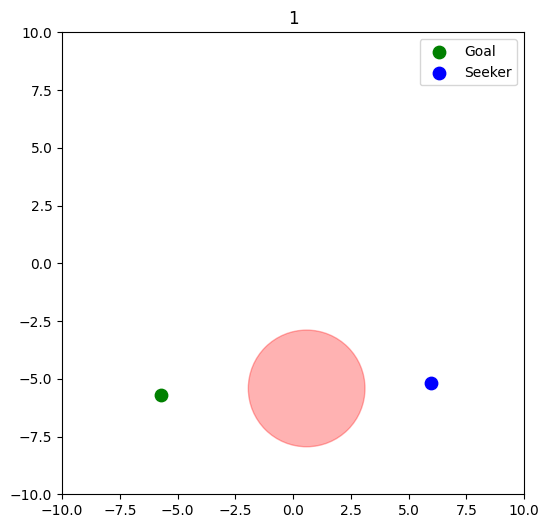

In [10]:
# number of obstacles this env actually has:
num_obstacles = (len(obs) - 4) // 3
# also just env._num_obstacles (?)

# reset real env
obs, info = env_real.reset()
plot_seeker_obs(obs, info, num_obstacles)

# randomize=True should give different positions over next two plots, but always same due to numpy rng seed

In [11]:
print(obs)

[ 5.98396753 -5.17789601 -5.72715059 -5.69871882  0.58691692 -5.41791639
  2.52576318]


In [12]:
# should be:
# [ 5.98396753 -5.17789601 -5.72715059 -5.69871882  0.58691692 -5.41791639
#   2.52576318]
obs == [5.98396753, -5.17789601, -5.72715059, -5.69871882, 0.58691692, -5.41791639, 2.52576318]

array([False, False, False, False, False, False, False])

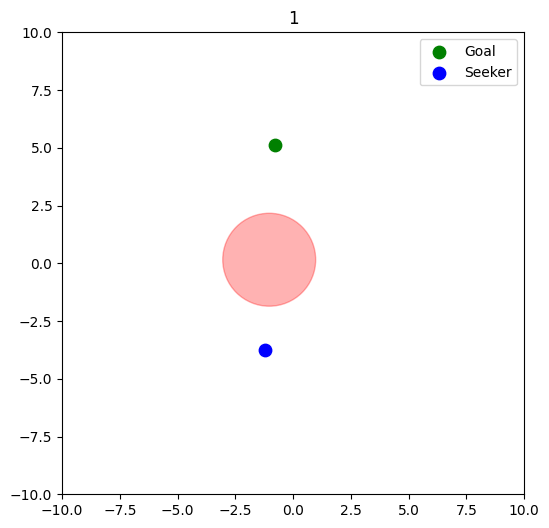

In [13]:
# reset real env -> different setup, but same different every time notebook is restarted ?
obs, info = env_real.reset()
plot_seeker_obs(obs, info, num_obstacles)

# randomize=True should give different positions over next two plots, but always same due to numpy rng seed

In [14]:
print(obs)

[-1.22498966 -3.75787548 -0.79074028  5.13316731 -1.03394827  0.15360326
  2.01160903]


In [15]:
# should be:
# [-1.22498966 -3.75787548 -0.79074028  5.13316731 -1.03394827  0.15360326
#   2.01160903]
obs == [-1.22498966, -3.75787548, -0.79074028, 5.13316731, -1.03394827, 0.15360326, 2.01160903]
# FAILS DUE TO ACTUALLY obs[0] (as an example) BEING -1.2249896644419165

array([False, False, False, False, False, False, False])

# create buffer, collect data, train, and log losses

## buffer and logging containers; schedules

In [16]:
# Buffer
replay = ReplayBufferHybrid(
    capacity=cfg.replay_buffer_capacity,
    obs_dim=obs_dim,
    action_dim=action_dim,
    K_max=32,
)

# Logging containers (easy to plot later)
logs = {
    "loss_total": [],
    "loss_value": [],
    "loss_policy": [],
    "loss_policy_distill": [],
    "loss_mu": [],
    "loss_log_std": [],
    "ep_return": [],
    "ep_length": [],
    "eval_return_mean": [],
    "eval_return_std": [],
    "eval_length_mean": [],
    "success_rate": [],
    "collision_rate": [],
    "iter_idx_eval": [],
}

# Training OVERFIT FOR DEBUGGING

In [17]:
DEBUG_DIR = "debug_traces"
os.makedirs(DEBUG_DIR, exist_ok=True)

DEBUG_EVERY = 10          # e.g. every 50 training episodes
DEBUG_SEED = EVAL_SEEDS[-1]            # fixed seed for comparability
DEBUG_RECORD_EVERY = 1    # or 2/5 if trees are big
DEBUG_MAX_STEPS = 200

DEBUG_OBS, _ = env_real.reset(seed=DEBUG_SEED)
print(DEBUG_OBS)

[ 1.66346224 -8.16389257 -7.82907133  8.07993967 -3.96681008  1.47075328
  5.26135827]


In [18]:
import time

num_iters = 300

start_time = time.perf_counter()
print("start")
eval_data = []
SEED = SEED +2
#SEED gives len 200, SEED +2 gives len 37. Only used in planner.

for it in range(num_iters):
    now = time.perf_counter()
    print(f"main loop iter: {it}")
    print(f"time: {now-start_time}")
    last_time = now
    
    planner.set_training_iter(it)

    # ---- DEBUG EVAL EPISODE ----
    set_global_seeds(SEED)
    planner.rng = np.random.default_rng(SEED)
    dbg = run_debug_eval_episode(
            env_eval=env_eval,
            planner=planner,
            seed=DEBUG_SEED,
            max_steps=DEBUG_MAX_STEPS,
            obs=DEBUG_OBS,
        )
    dbg["train_episode"] = it  # handy metadata

    path = os.path.join(DEBUG_DIR, f"trace_ep{it:06d}_seed{DEBUG_SEED}.pkl")
    
    with open(path, "wb") as f:
        pickle.dump(dbg, f)
    
    now = time.perf_counter()
    print("DEBUG time:", now - last_time)
    last_time = now
    
    # ---- Collect ----
    set_global_seeds(SEED)
    planner.rng = np.random.default_rng(SEED)
    stats, roots_collect = collect_one_episode_hybrid(
        env_real=env_real,
        planner=planner,
        replay_buffer=replay,
        max_steps=cfg.max_episode_steps,
        gamma=cfg.gamma,
        training=False,
        obs=DEBUG_OBS,
    )
    now = time.perf_counter()
    print("collect loop time:", now - last_time)
    last_time = now
    print("Stats from collect loop: ", stats)

    # ---- Train (baseline MLE/value regression) ----
    for _ in range(cfg.train_steps_per_iter):
        batch = replay.sample(cfg.batch_size, device=device, rng=np.random.default_rng(SEED))
        loss_dict = train_step_mle(
            net=net,
            optimizer=optimizer,
            batch=batch,
            w_value=cfg.value_loss_weight,
            w_policy=cfg.policy_loss_weight,
            grad_clip_norm=1.0,
        )
        for k, v in loss_dict.items():
            logs[k].append(v)
    now = time.perf_counter()
    print("train loop time:", now - last_time)
    last_time = now
    
        

    last_loss = logs["loss_total"][-1] if logs["loss_total"] else None
    print(
        f"Iter {it} | replay={len(replay)} | "
        #f"train_return_mean={np.mean(ep_returns):.2f} | last_loss={last_loss}"
        f"last_loss={last_loss}"
    )


start
main loop iter: 0
time: 0.0004121000001759967
DEBUG: EVAL DEBUG EPISODE RUN WITH OBS: [ 1.66346224 -8.16389257 -7.82907133  8.07993967 -3.96681008  1.47075328
  5.26135827]
DEBUG time: 2.0171205000001464
DEBUG: COLLECTION RUN WITH OBS: [ 1.66346224 -8.16389257 -7.82907133  8.07993967 -3.96681008  1.47075328
  5.26135827]
collect loop time: 2.0078780999997434
Stats from collect loop:  {'return': 81.74000247308022, 'length': 37, 'done': True, 'terminated': True, 'truncated': False}
train loop time: 0.39737379999996847
Iter 0 | replay=37 | last_loss=0.04797546565532684
main loop iter: 1
time: 4.423020800000359
DEBUG: EVAL DEBUG EPISODE RUN WITH OBS: [ 1.66346224 -8.16389257 -7.82907133  8.07993967 -3.96681008  1.47075328
  5.26135827]
DEBUG time: 11.599651499999709
DEBUG: COLLECTION RUN WITH OBS: [ 1.66346224 -8.16389257 -7.82907133  8.07993967 -3.96681008  1.47075328
  5.26135827]
collect loop time: 10.928524599999946
Stats from collect loop:  {'return': -192.0141203127383, 'length

In [19]:
stats

{'return': 88.74437197637162,
 'length': 30,
 'done': True,
 'terminated': True,
 'truncated': False}

In [20]:
len(replay)

11918

In [21]:
cfg.batch_size

128

# Debug Plots

## load debug pickle data

In [39]:
import gc
import matplotlib.pyplot as plt

plt.close("all")   # release figure refs
try:
    del dbg
except NameError:
    pass
gc.collect()

from IPython.display import clear_output
clear_output(wait=True)

with open("debug_traces/trace_ep000299_seed1009.pkl", "rb") as f:
    dbg = pickle.load(f)

In [40]:
dbg.keys()

dict_keys(['seed', 'info', 'states', 'roots', 'chosen_idx', 'actions', 'network_outputs', 'targets_from_root', 'train_episode'])

In [41]:
from graphviz import Digraph

def mcts_to_graphviz(root, *, depth_limit=None, max_nodes=2000, highlight_child_idx=None):
    """
    Build a Graphviz Digraph for an MCTS tree rooted at `root`.

    depth_limit: None for full depth, or int to cap depth
    max_nodes: stop after this many nodes (safety)
    highlight_child_idx: if given, highlight that root child edge/node
    """
    dot = Digraph(comment="MCTS Tree")
    dot.attr("node", shape="box", fontsize="10")
    dot.attr("edge", fontsize="9")

    # Assign stable ids
    node_id = {}
    next_id = 0

    def get_id(node):
        nonlocal next_id
        k = id(node)
        if k not in node_id:
            node_id[k] = f"n{next_id}"
            next_id += 1
        return node_id[k]

    # BFS/DFS traversal
    stack = [(root, 0)]
    seen = set()
    created = 0

    while stack:
        node, depth = stack.pop()
        nid = get_id(node)

        if nid in seen:
            continue
        seen.add(nid)

        # Stop conditions
        if created >= max_nodes:
            break
        if depth_limit is not None and depth > depth_limit:
            continue

        # Node label
        N = getattr(node, "N", 0)
        v = getattr(node, "v", None)
        is_term = getattr(node, "is_terminal", False)
        term_v = getattr(node, "terminal_value", None)

        label = f"N={N}"
        if v is not None:
            label += f"\\nv={float(v):.3f}"
        if is_term:
            label += "\\nTERMINAL"
            if term_v is not None:
                label += f"\\nTv={float(term_v):.3f}"

        # Style terminal nodes
        if is_term:
            dot.node(nid, label=label, style="filled", fillcolor="lightgray")
        else:
            dot.node(nid, label=label)

        created += 1

        # Children edges
        children = getattr(node, "children", [])
        for i, ch in enumerate(children):
            child = ch.child_node
            cid = get_id(child)

            # Edge label includes stats
            a = np.array(ch.action).tolist()
            edge_label = (
                f"a={a}"
                f"\\nr={float(ch.r_sa):.3f}"
                f"\\nN={int(ch.N_sa)}"
                f"\\nQ={float(ch.Q_sa):.3f}"
                f"\\nP={float(ch.P_sa):.3g}"
            )

            # Highlight chosen root child
            if node is root and highlight_child_idx is not None and i == int(highlight_child_idx):
                dot.edge(nid, cid, label=edge_label, penwidth="3")
                dot.node(cid, style="filled", fillcolor="palegreen")
            else:
                dot.edge(nid, cid, label=edge_label)

            # Continue traversal
            stack.append((child, depth + 1))

    if created >= max_nodes:
        # Add a note node
        dot.node("TRUNC", f"TRUNCATED at max_nodes={max_nodes}", style="filled", fillcolor="orange")
    return dot

In [42]:
from ipywidgets import interact, IntSlider

def inspect_debug_trace(dbg, *, depth_limit=3, max_nodes=2000):
    states = dbg["states"]
    roots = dbg["roots"]
    chosen = dbg["chosen_idx"]
    info = dbg["info"]
    record_every = max(1, int(dbg.get("record_every", 1)))  # optional if you store it

    def view(k):
        # k indexes into recorded roots
        env_t = k * record_every

        # state plot
        plot_seeker_obs(states[env_t], info, title=f"Seed={dbg['seed']} | train_ep={dbg.get('train_episode')} | t={env_t}")

        # tree plot
        dot = mcts_to_graphviz(
            roots[k],
            depth_limit=depth_limit,
            max_nodes=max_nodes,
            highlight_child_idx=chosen[k],
        )
        return dot

    interact(view, k=IntSlider(min=0, max=len(roots)-1, step=1, value=0))


In [43]:
inspect_debug_trace(dbg, depth_limit=10, max_nodes=2000)

interactive(children=(IntSlider(value=0, description='k', max=29), Output(outputs=({'output_type': 'display_da…

In [44]:
def collect_tree_edges(root, depth_limit=None, max_nodes=5000):
    """
    Traverse the tree and collect (parent_node, child_node, child_edge, depth_child).
    """
    edges = []
    stack = [(root, 0)]
    seen = set()
    node_count = 0

    while stack:
        node, depth = stack.pop()
        node_id = id(node)
        if node_id in seen:
            continue
        seen.add(node_id)
        node_count += 1
        if node_count > max_nodes:
            break

        if depth_limit is not None and depth >= depth_limit:
            continue

        for ch in getattr(node, "children", []):
            child = ch.child_node
            edges.append((node, child, ch, depth + 1))
            stack.append((child, depth + 1))

    return edges


def plot_mcts_tree_xy(
    root,
    info,
    chosen_child_idx=None,
    depth_limit=6,
    max_nodes=4000,
    show_edge_text=False,
    highlight_subtree=False,
    title=None,
):
    """
    Visualize an MCTS tree in environment XY coordinates.
    - chosen_child_idx highlights the root->child edge that planner.act picked.
    - highlight_subtree: if True, highlight the entire subtree under chosen child.
    """
    root_obs = root.state
    agent0, goal, obstacles = decode_obs(root_obs)
    L = info.get("boundary_size", 10)

    edges = collect_tree_edges(root, depth_limit=depth_limit, max_nodes=max_nodes)

    # Precompute positions
    def pos(node):
        a, _, _ = decode_obs(node.state)
        return float(a[0]), float(a[1])

    # Determine which nodes/edges are in the chosen subtree (optional)
    chosen_subtree_nodes = set()
    chosen_child_node = None
    if chosen_child_idx is not None and 0 <= chosen_child_idx < len(root.children):
        chosen_child_node = root.children[int(chosen_child_idx)].child_node

    if highlight_subtree and chosen_child_node is not None:
        stack = [chosen_child_node]
        while stack:
            n = stack.pop()
            if id(n) in chosen_subtree_nodes:
                continue
            chosen_subtree_nodes.add(id(n))
            for ch in getattr(n, "children", []):
                stack.append(ch.child_node)

    fig, ax = plt.subplots(figsize=(7, 7))

    # Obstacles
    for (ox, oy, r) in obstacles:
        ax.add_patch(plt.Circle((ox, oy), r, alpha=0.3))
    # Goal / Agent
    ax.scatter(goal[0], goal[1], s=140, marker="*", label="Goal", zorder=5)
    ax.scatter(agent0[0], agent0[1], s=90, label="Root state", zorder=6)

    # Draw edges + nodes
    # Draw non-highlight edges first
    for parent, child, ch, d in edges:
        x0, y0 = pos(parent)
        x1, y1 = pos(child)

        is_chosen_edge = (parent is root and chosen_child_node is child)
        in_chosen_subtree = (highlight_subtree and id(child) in chosen_subtree_nodes)

        # Edge style
        if is_chosen_edge:
            lw = 3.0
            alpha = 0.9
        elif in_chosen_subtree:
            lw = 2.0
            alpha = 0.6
        else:
            lw = 1.0
            alpha = 0.25

        ax.plot([x0, x1], [y0, y1], linewidth=lw, alpha=alpha, zorder=1)

        if show_edge_text:
            mx, my = (x0 + x1) / 2, (y0 + y1) / 2
            ax.text(
                mx, my,
                f"N={ch.N_sa}\nQ={ch.Q_sa:.2f}\nP={ch.P_sa:.2g}",
                fontsize=7,
                alpha=0.8,
                ha="center", va="center"
            )

    # Scatter nodes (child endpoints)
    xs, ys, sizes, alphas = [], [], [], []
    xs_hi, ys_hi = [], []
    for parent, child, ch, d in edges:
        x1, y1 = pos(child)
        xs.append(x1); ys.append(y1)
        sizes.append(18 + 6 * min(d, 6))
        alphas.append(0.15 + 0.10 * (depth_limit - d) if depth_limit else 0.2)

        if chosen_child_node is child:
            xs_hi.append(x1); ys_hi.append(y1)

    ax.scatter(xs, ys, s=sizes, alpha=0.35, label="Tree nodes", zorder=3)
    if xs_hi:
        ax.scatter(xs_hi, ys_hi, s=140, alpha=0.95, label="Chosen child", zorder=7)

    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="upper right")

    if title:
        ax.set_title(title)

    # Print root-child stats as a small table-like text
    if len(getattr(root, "children", [])) > 0:
        lines = ["Root children (sorted by N):"]
        rows = []
        for i, ch in enumerate(root.children):
            rows.append((i, ch.N_sa, ch.Q_sa, ch.P_sa, ch.r_sa, np.array(ch.action)))
        rows.sort(key=lambda r: r[1], reverse=True)

        for (i, N, Q, P, r, a) in rows[:12]:  # top 12
            star = " <= chosen" if (chosen_child_idx is not None and i == int(chosen_child_idx)) else ""
            lines.append(f"[{i}] N={N:4d}  Q={Q:7.3f}  P={P:8.3g}  r={r:7.3f}  a={a}{star}")

        # place text under plot
        fig.text(0.02, 0.02, "\n".join(lines), fontsize=9, va="bottom")

    plt.show()
    return fig


In [45]:
from ipywidgets import interact, IntSlider

def inspect_debug_trace_xy(dbg, *, depth_limit=6, max_nodes=4000, show_edge_text=False, highlight_subtree=False):
    roots = dbg["roots"]
    chosen = dbg["chosen_idx"]
    info = dbg["info"]
    record_every = max(1, int(dbg.get("record_every", 1)))

    def view(k):
        env_t = k * record_every
        plot_mcts_tree_xy(
            roots[k],
            info,
            chosen_child_idx=chosen[k] if k < len(chosen) else None,
            depth_limit=depth_limit,
            max_nodes=max_nodes,
            show_edge_text=show_edge_text,
            highlight_subtree=highlight_subtree,
            title=f"Seed={dbg['seed']} | train_ep={dbg.get('train_episode')} | t={env_t}"
        )

    interact(view, k=IntSlider(min=0, max=len(roots)-1, step=1, value=0))


In [46]:
#dbg = run_debug_eval_episode(env_eval=env_eval, planner=planner, seed=0, max_steps=200, record_every=1)
#dbg["record_every"] = 1
#dbg["train_episode"] = 500

inspect_debug_trace_xy(dbg, depth_limit=3, max_nodes=4000, highlight_subtree=True)

interactive(children=(IntSlider(value=0, description='k', max=29), Output()), _dom_classes=('widget-interact',…

## Plot for seeker trajectory

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def plot_seeker_trajectory(states, title=None, cmap="viridis",
                           show_line=True, show_points=True, annotate=False):
    """
    states: list/iterable of obs vectors (each encodes agent, goal, obstacles)
    info: dict with boundary_size etc.
    """
    if len(states) == 0:
        return

    # Use first state for static elements (goal/obstacles/boundary)
    agent0, goal, obstacles = decode_obs(states[0])
    L = 10

    # Extract agent positions over time
    agents = np.array([decode_obs(s)[0] for s in states])  # shape (T, 2)
    T = len(agents)
    t = np.arange(T)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Obstacles
    for (ox, oy, r) in obstacles:
        ax.add_patch(plt.Circle((ox, oy), r, color="red", alpha=0.3))

    # Goal
    ax.scatter(goal[0], goal[1], color="green", s=120, marker="*", label="Goal", zorder=3)

    # Trajectory
    if show_line:
        ax.plot(agents[:, 0], agents[:, 1], linewidth=2, alpha=0.7, label="Path", zorder=2)

    if show_points:
        sc = ax.scatter(
            agents[:, 0], agents[:, 1],
            c=t, cmap=cmap, s=35, zorder=4
        )
        plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="Step")

    # Start / End markers
    ax.scatter(agents[0, 0], agents[0, 1], color="cyan", s=90, label="Start", zorder=5)
    ax.scatter(agents[-1, 0], agents[-1, 1], color="black", s=90, label="End", zorder=5)

    if annotate:
        for i, (x, y) in enumerate(agents):
            ax.text(x, y, str(i), fontsize=8)

    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="upper right")
    if title:
        ax.set_title(title)
    plt.show()


### Trajectory from debug eval

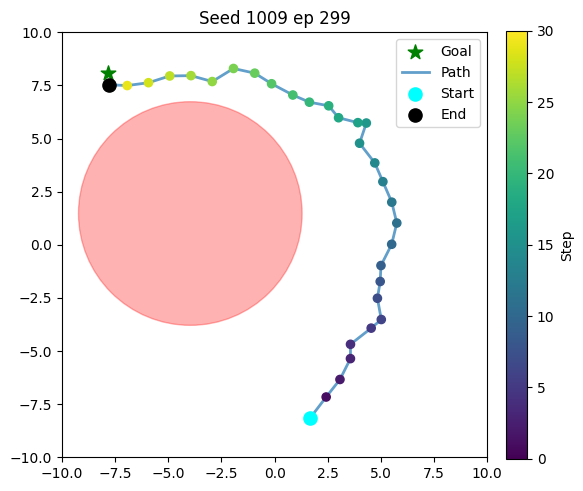

In [48]:
plot_seeker_trajectory(dbg["states"], title=f"Seed {dbg['seed']} ep {dbg.get('train_episode')}")

### Trajectory from data collection

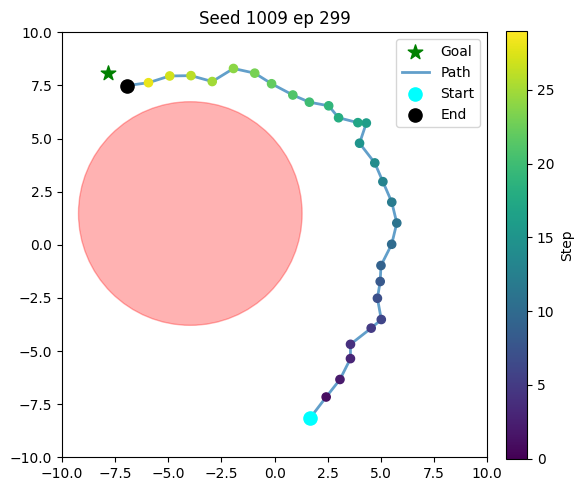

In [49]:
states_collect = [np.asarray(r.state).copy() for r in roots_collect]
plot_seeker_trajectory(states_collect, title=f"Seed {dbg['seed']} ep {dbg.get('train_episode')}")

#### At this point I know, that debug and train collection are the same.

## More comparisons between train and debug just for sanity

## Plot for MCTS tree

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mcts_tree_xy(
    root,
    obs,
    *,
    L=10,
    title=None,
    ax=None,
    chosen_child_idx=None,
):
    """Full tree in XY, with optional highlight of the chosen root child."""
    agent, goal, obstacles = decode_obs(obs)

    def node_xy(node):
        a, _, _ = decode_obs(np.asarray(node.state))
        return float(a[0]), float(a[1])

    # identify chosen child node (optional)
    chosen_child_node = None
    if chosen_child_idx is not None and 0 <= int(chosen_child_idx) < len(getattr(root, "children", [])):
        chosen_child_node = root.children[int(chosen_child_idx)].child_node

    # traverse tree
    edges = []  # (parent, child, is_chosen_root_edge)
    stack = [root]
    seen = set()

    while stack:
        node = stack.pop()
        nid = id(node)
        if nid in seen:
            continue
        seen.add(nid)

        for ch in getattr(node, "children", []):
            child = ch.child_node
            is_chosen = (node is root and chosen_child_node is child)
            edges.append((node, child, is_chosen))
            stack.append(child)

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    # obstacles
    for (ox, oy, r) in obstacles:
        ax.add_patch(plt.Circle((ox, oy), r, alpha=0.3))

    # goal and agent
    ax.scatter(goal[0], goal[1], s=120, marker="*", label="Goal", zorder=5)
    ax.scatter(agent[0], agent[1], s=90, label="Agent (obs)", zorder=6)

    # edges
    for parent, child, is_chosen in edges:
        x0, y0 = node_xy(parent)
        x1, y1 = node_xy(child)
        if is_chosen:
            ax.plot([x0, x1], [y0, y1], linewidth=3, alpha=0.9, label="Chosen edge", zorder=2)
        else:
            ax.plot([x0, x1], [y0, y1], linewidth=1, alpha=0.35, zorder=1)

    # nodes
    xs, ys = [], []
    for _, child, _ in edges:
        x, y = node_xy(child)
        xs.append(x); ys.append(y)

    xr, yr = node_xy(root)
    ax.scatter([xr], [yr], s=80, marker="s", label="MCTS root", zorder=7)
    if xs:
        ax.scatter(xs, ys, s=20, alpha=0.5, label="Tree nodes", zorder=3)

    # highlight chosen child node
    if chosen_child_node is not None:
        xc, yc = node_xy(chosen_child_node)
        ax.scatter([xc], [yc], s=110, alpha=0.9, label="Chosen child", zorder=8)

    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect("equal", adjustable="box")
    if title:
        ax.set_title(title)
    return ax


def plot_mcts_tree_xy_limited(
    root,
    obs,
    *,
    L=10,
    title=None,
    ax=None,
    max_depth=6,
    top_k_per_node=5,
    chosen_child_idx=None,
):
    """Tree in XY, limited by depth and top-K children per node, with chosen root child highlight."""
    agent, goal, obstacles = decode_obs(obs)

    def node_xy(node):
        a, _, _ = decode_obs(np.asarray(node.state))
        return float(a[0]), float(a[1])

    chosen_child_node = None
    if chosen_child_idx is not None and 0 <= int(chosen_child_idx) < len(getattr(root, "children", [])):
        chosen_child_node = root.children[int(chosen_child_idx)].child_node

    edges = []  # (parent, child, is_chosen_root_edge)
    stack = [(root, 0)]
    seen = set()

    while stack:
        node, depth = stack.pop()
        nid = id(node)
        if nid in seen:
            continue
        seen.add(nid)

        if depth >= int(max_depth):
            continue

        children = list(getattr(node, "children", []))
        children.sort(key=lambda ch: ch.N_sa, reverse=True)
        children = children[: int(top_k_per_node)]

        for ch in children:
            child = ch.child_node
            is_chosen = (node is root and chosen_child_node is child)
            edges.append((node, child, is_chosen))
            stack.append((child, depth + 1))

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    for (ox, oy, r) in obstacles:
        ax.add_patch(plt.Circle((ox, oy), r, alpha=0.3))

    ax.scatter(goal[0], goal[1], s=120, marker="*", label="Goal", zorder=5)
    ax.scatter(agent[0], agent[1], s=90, label="Agent (obs)", zorder=6)

    for parent, child, is_chosen in edges:
        x0, y0 = node_xy(parent)
        x1, y1 = node_xy(child)
        if is_chosen:
            ax.plot([x0, x1], [y0, y1], linewidth=3, alpha=0.9, label="Chosen edge", zorder=2)
        else:
            ax.plot([x0, x1], [y0, y1], linewidth=1, alpha=0.35, zorder=1)

    xs, ys = [], []
    for _, child, _ in edges:
        x, y = node_xy(child)
        xs.append(x); ys.append(y)

    xr, yr = node_xy(root)
    ax.scatter([xr], [yr], s=80, marker="s", label="MCTS root", zorder=7)
    if xs:
        ax.scatter(xs, ys, s=20, alpha=0.5, label="Tree nodes", zorder=3)

    if chosen_child_node is not None:
        xc, yc = node_xy(chosen_child_node)
        ax.scatter([xc], [yc], s=110, alpha=0.9, label="Chosen child", zorder=8)

    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect("equal", adjustable="box")
    if title:
        ax.set_title(title)
    return ax

Have same length:  True


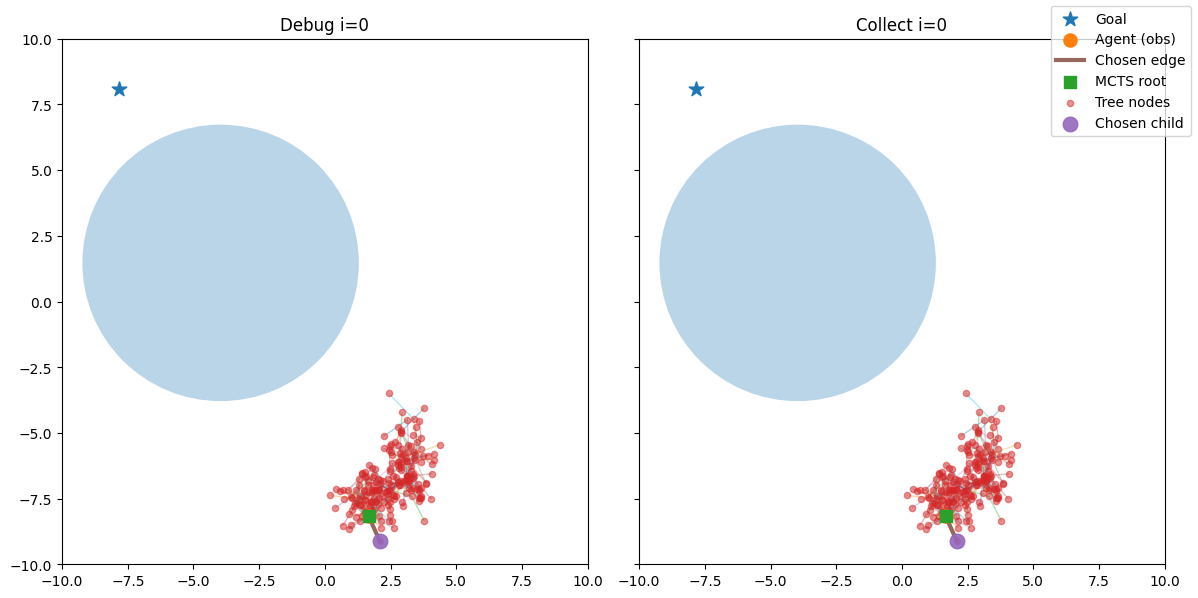

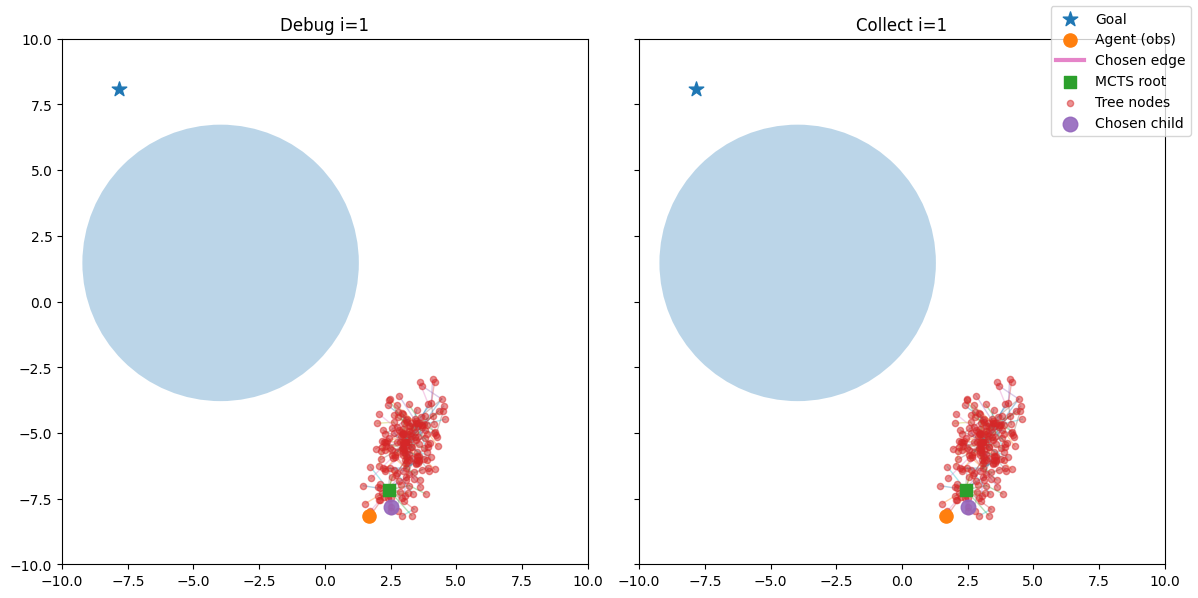

In [51]:
print("Have same length: ", bool(len(dbg["roots"]) == len(roots_collect)))

n = min(len(dbg["roots"]), len(roots_collect))
n = 2

for i in range(n):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    idx = int(np.argmin([np.max(np.abs(ch.action - action)) for ch in dbg["roots"][i].children]))
    plot_mcts_tree_xy(dbg["roots"][i], DEBUG_OBS, ax=axes[0], title=f"Debug i={i}", chosen_child_idx=idx)

    idx = int(np.argmin([np.max(np.abs(ch.action - action)) for ch in roots_collect[i].children]))
    plot_mcts_tree_xy(roots_collect[i], DEBUG_OBS, ax=axes[1], title=f"Collect i={i}", chosen_child_idx=idx)

    # show legend only once (optional)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()

Have same length:  True


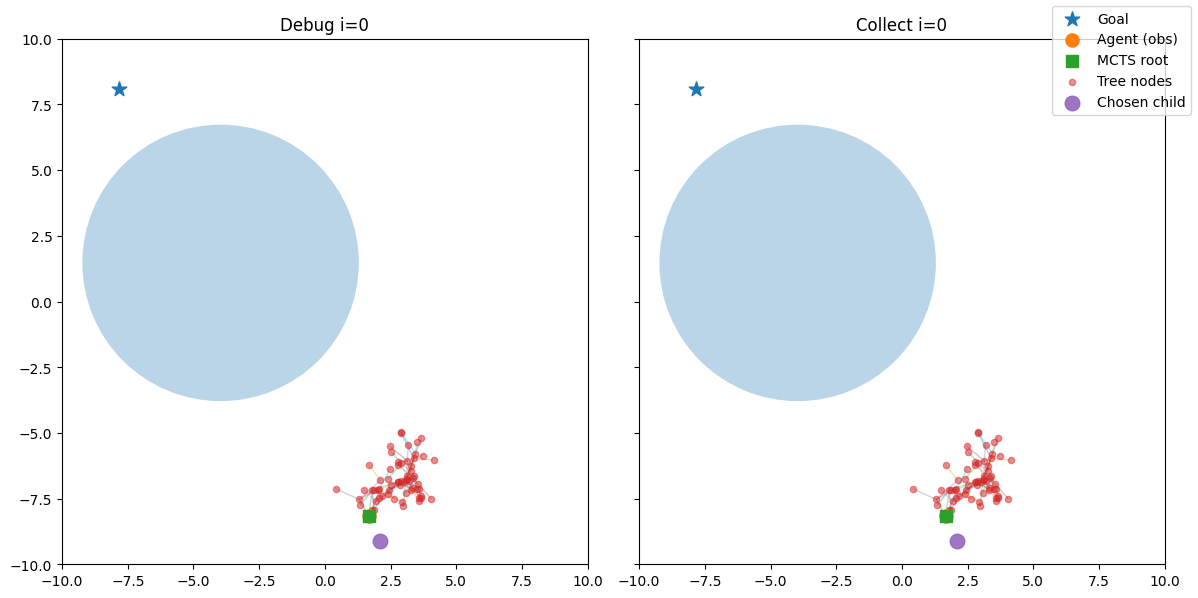

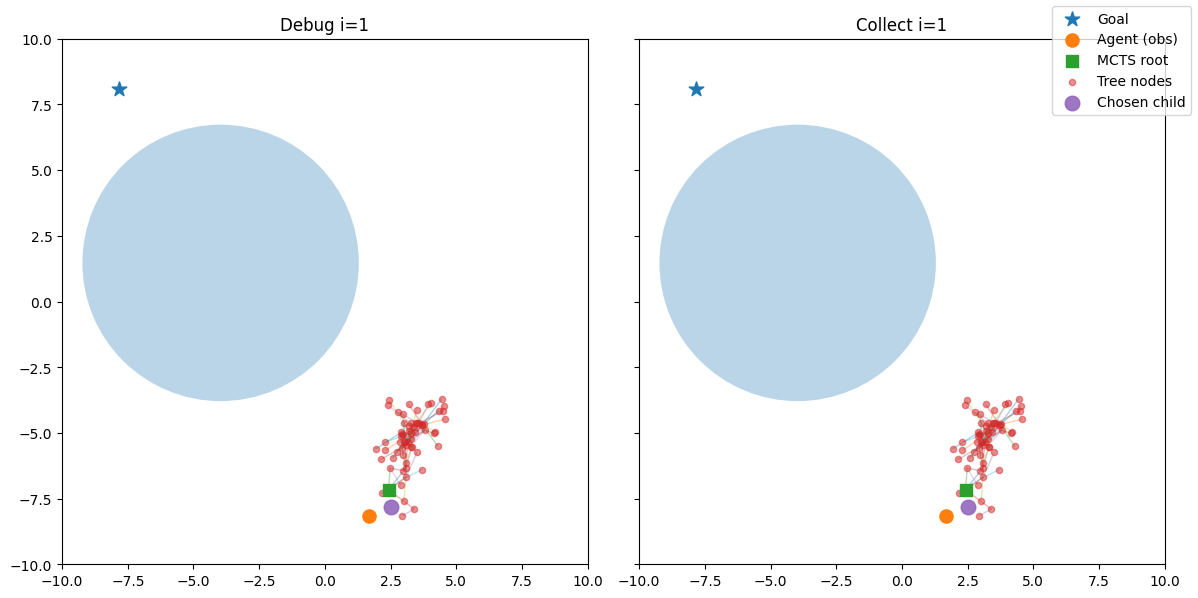

In [52]:
print("Have same length: ", bool(len(dbg["roots"]) == len(roots_collect)))

n = min(len(dbg["roots"]), len(roots_collect))
n = 2

for i in range(n):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    idx = int(np.argmin([np.max(np.abs(ch.action - action)) for ch in dbg["roots"][i].children]))
    plot_mcts_tree_xy_limited(dbg["roots"][i], DEBUG_OBS, ax=axes[0], title=f"Debug i={i}", max_depth=4, top_k_per_node=4, chosen_child_idx=idx)

    idx = int(np.argmin([np.max(np.abs(ch.action - action)) for ch in roots_collect[i].children]))
    plot_mcts_tree_xy_limited(roots_collect[i], DEBUG_OBS, ax=axes[1], title=f"Collect i={i}", max_depth=4, top_k_per_node=4, chosen_child_idx=idx)

    # show legend only once (optional)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()

## Plots for debugging the real issue (bad Q values)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_dbg_step(
    dbg,
    k: int,
    *,
    L=10,
    max_depth=6,
    top_k_per_node=5,
    title=None,
    ax=None,
    nsig=1.0,  # ellipse radius in "number of std devs"
):
    roots = dbg["roots"]
    states = dbg["states"]
    chosen_idx = dbg["chosen_idx"]
    net_out = dbg["network_outputs"]
    tgt_out = dbg["targets_from_root"]

    if k < 0 or k >= len(roots):
        raise IndexError(f"k={k} out of range, have {len(roots)} roots")

    root = roots[k]
    obs_k = states[k]
    agent, goal, obstacles = decode_obs(obs_k)

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    # --- environment ---
    for (ox, oy, r) in obstacles:
        ax.add_patch(plt.Circle((ox, oy), r, alpha=0.3))
    ax.scatter(goal[0], goal[1], s=120, marker="*", label="Goal", zorder=6)

    # --- past trajectory (0..k) ---
    agents = np.array([decode_obs(s)[0] for s in states[: k + 1]])
    t = np.arange(len(agents))
    ax.plot(agents[:, 0], agents[:, 1], linewidth=2, alpha=0.5, zorder=2)
    sc = ax.scatter(agents[:, 0], agents[:, 1], c=t, cmap="viridis", s=25, zorder=3)
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="t")

    ax.scatter(agents[0, 0], agents[0, 1], s=80, label="Start", zorder=7)
    ax.scatter(agent[0], agent[1], s=90, label=f"Agent @ t={k}", zorder=8)

    # --- helpers for tree ---
    def node_xy(node):
        a, _, _ = decode_obs(np.asarray(node.state))
        return float(a[0]), float(a[1])

    # chosen child node
    chosen_child_node = None
    cidx = int(chosen_idx[k]) if k < len(chosen_idx) else None
    if cidx is not None and 0 <= cidx < len(getattr(root, "children", [])):
        chosen_child_node = root.children[cidx].child_node

    # traverse limited tree
    edges = []
    stack = [(root, 0)]
    seen = set()

    while stack:
        node, depth = stack.pop()
        nid = id(node)
        if nid in seen:
            continue
        seen.add(nid)

        if depth >= int(max_depth):
            continue

        children = list(getattr(node, "children", []))
        children.sort(key=lambda ch: ch.N_sa, reverse=True)
        children = children[: int(top_k_per_node)]

        for ch in children:
            child = ch.child_node
            is_chosen = (node is root and chosen_child_node is child)
            edges.append((node, child, is_chosen))
            stack.append((child, depth + 1))

    for parent, child, is_chosen in edges:
        x0, y0 = node_xy(parent)
        x1, y1 = node_xy(child)
        if is_chosen:
            ax.plot([x0, x1], [y0, y1], linewidth=3, alpha=0.9, zorder=5)
        else:
            ax.plot([x0, x1], [y0, y1], linewidth=1, alpha=0.25, zorder=4)

    xs, ys = [], []
    for _, child, _ in edges:
        x, y = node_xy(child)
        xs.append(x); ys.append(y)

    xr, yr = node_xy(root)
    ax.scatter([xr], [yr], s=70, marker="s", label="MCTS root", zorder=9)
    if xs:
        ax.scatter(xs, ys, s=18, alpha=0.35, zorder=6)

    if chosen_child_node is not None:
        xc, yc = node_xy(chosen_child_node)
        ax.scatter([xc], [yc], s=120, alpha=0.9, label="Chosen child", zorder=10)

    # --- Gaussian ellipses (assumes action is delta-x, delta-y) ---
    mu, log_std, v = net_out[k]
    mu = np.asarray(mu).reshape(-1)
    std = np.exp(np.asarray(log_std).reshape(-1))

    mu_s, log_std_s, v_s = tgt_out[k]
    mu_s = np.asarray(mu_s).reshape(-1)
    std_s = np.exp(np.asarray(log_std_s).reshape(-1))

    c_net = np.array([agent[0], agent[1]]) + mu[:2]
    c_tgt = np.array([agent[0], agent[1]]) + mu_s[:2]

    # arrows (colored)
    ax.arrow(agent[0], agent[1], c_net[0]-agent[0], c_net[1]-agent[1],
             length_includes_head=True, head_width=0.15, alpha=0.8,
             color="steelblue", zorder=11)
    ax.arrow(agent[0], agent[1], c_tgt[0]-agent[0], c_tgt[1]-agent[1],
             length_includes_head=True, head_width=0.15, alpha=0.8,
             color="orange", zorder=11)

    w_net = 2.0 * nsig * float(std[0]);  h_net = 2.0 * nsig * float(std[1])
    w_tgt = 2.0 * nsig * float(std_s[0]); h_tgt = 2.0 * nsig * float(std_s[1])

    # ellipses (colored, not dashed)
    ax.add_patch(Ellipse((c_net[0], c_net[1]), w_net, h_net,
                         angle=0.0, fill=False, linewidth=2,
                         edgecolor="steelblue", alpha=0.9, label="Net (μ,σ)"))
    ax.add_patch(Ellipse((c_tgt[0], c_tgt[1]), w_tgt, h_tgt,
                         angle=0.0, fill=False, linewidth=2,
                         edgecolor="orange", alpha=0.9, label="Target (μ*,σ*)"))

    ax.text(0.02, 0.98, f"v={float(v):.3f}\nv*={float(v_s):.3f}",
            transform=ax.transAxes, va="top", fontsize=10)

    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title if title is not None else f"seed={dbg.get('seed')}  t={k}")

    ax.legend(loc="upper right")
    return ax

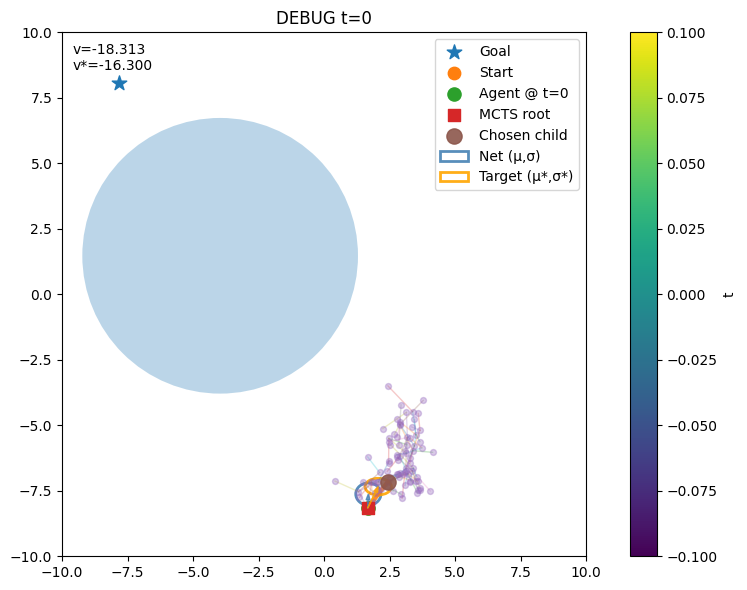

network: (array([0.02665485, 0.53967404], dtype=float32), array([-0.73151296, -0.8625963 ], dtype=float32), -18.313201904296875)
target: (array([0.4043007 , 0.82057744], dtype=float32), array([-0.6886046, -1.1440871], dtype=float32), -16.300286383999254)


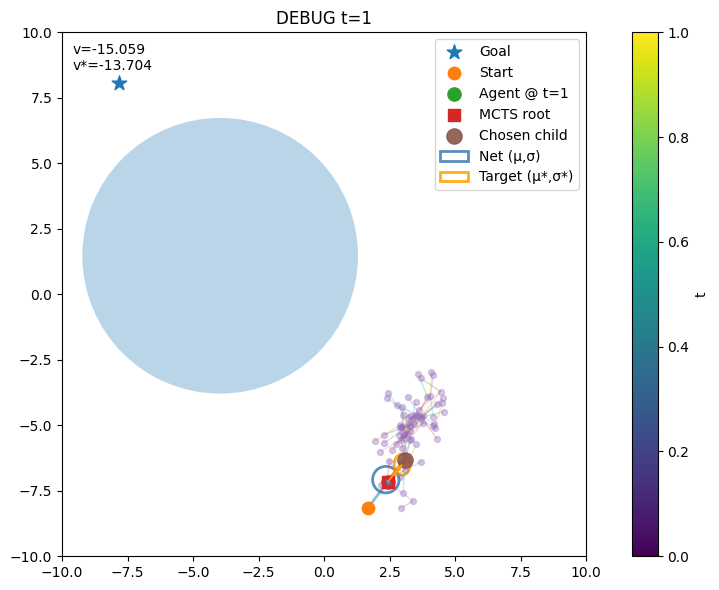

network: (array([-0.0683695 ,  0.08930015], dtype=float32), array([-0.6830022 , -0.68005157], dtype=float32), -15.058832168579102)
target: (array([0.5557866, 0.6647161], dtype=float32), array([-1.188596  , -0.90644634], dtype=float32), -13.703912768850406)


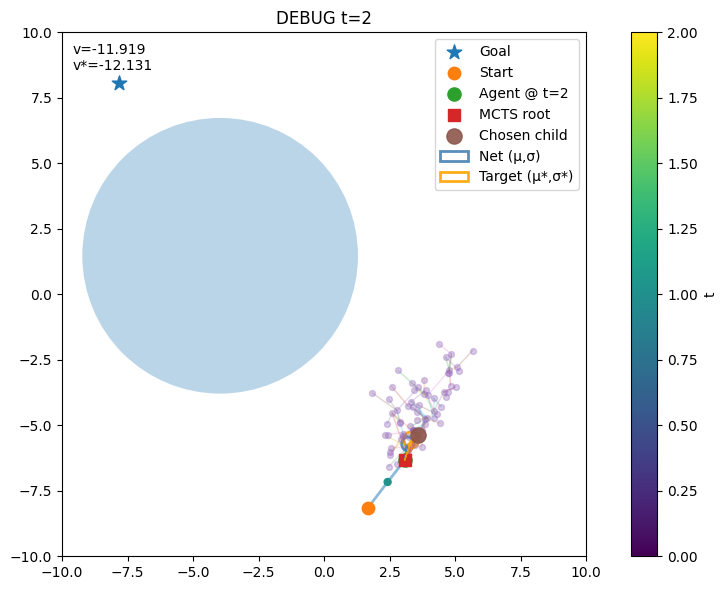

network: (array([0.11325587, 0.62735677], dtype=float32), array([-1.4849086, -1.3339835], dtype=float32), -11.918679237365723)
target: (array([0.25178224, 0.7801191 ], dtype=float32), array([-1.2449193, -1.1831007], dtype=float32), -12.130790960153947)


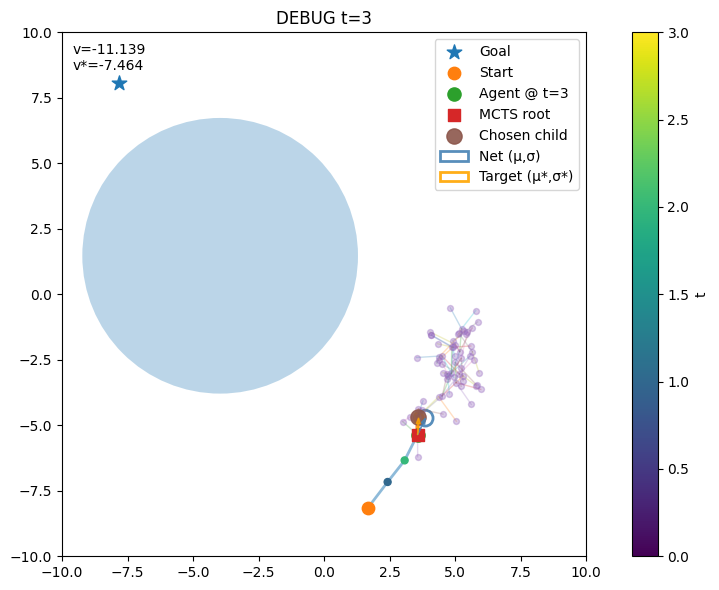

network: (array([0.3025844, 0.6290009], dtype=float32), array([-1.2427185, -1.1989468], dtype=float32), -11.13866901397705)
target: (array([0.03863385, 0.64021486], dtype=float32), array([-1.7900193, -1.5876371], dtype=float32), -7.46381247876395)


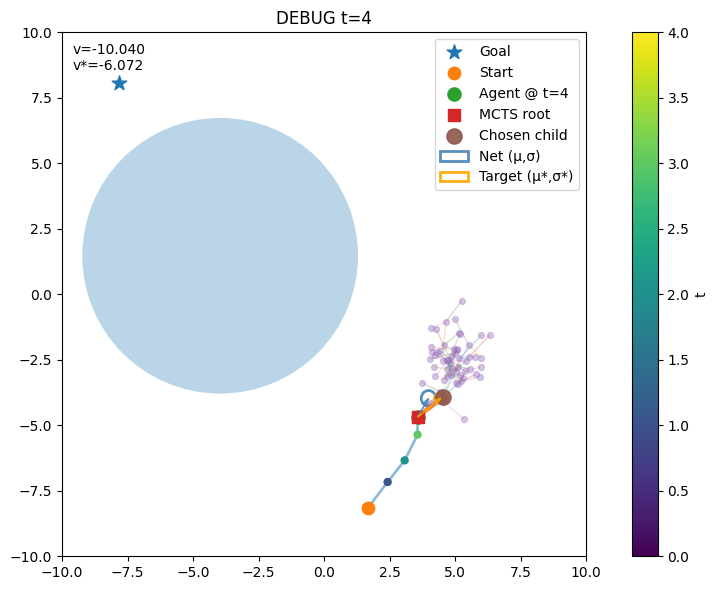

network: (array([0.41650546, 0.7129054 ], dtype=float32), array([-1.2778053, -1.2117918], dtype=float32), -10.040042877197266)
target: (array([0.8905548, 0.7263088], dtype=float32), array([-1.4472411, -1.6222578], dtype=float32), -6.071914608952999)


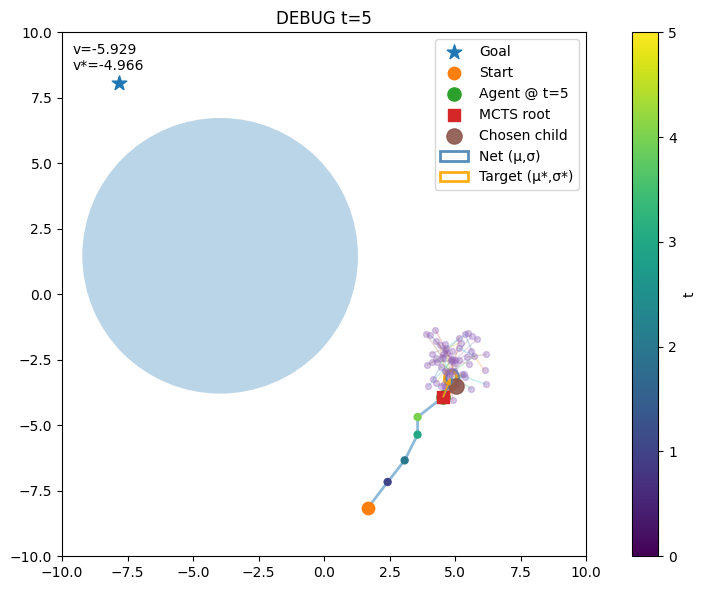

network: (array([0.3545717, 0.7348925], dtype=float32), array([-1.4474835, -1.1887295], dtype=float32), -5.929032802581787)
target: (array([0.27885893, 0.7067114 ], dtype=float32), array([-1.4426532, -1.2137871], dtype=float32), -4.966008936464944)


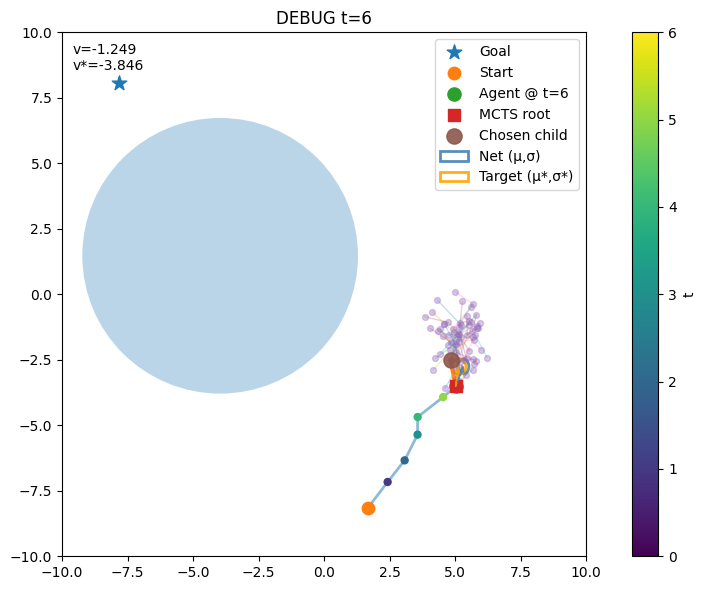

network: (array([0.3008052 , 0.76363623], dtype=float32), array([-1.5797334, -1.2671338], dtype=float32), -1.2488406896591187)
target: (array([0.11204083, 0.75607646], dtype=float32), array([-1.2674829, -1.1896523], dtype=float32), -3.846148302471572)


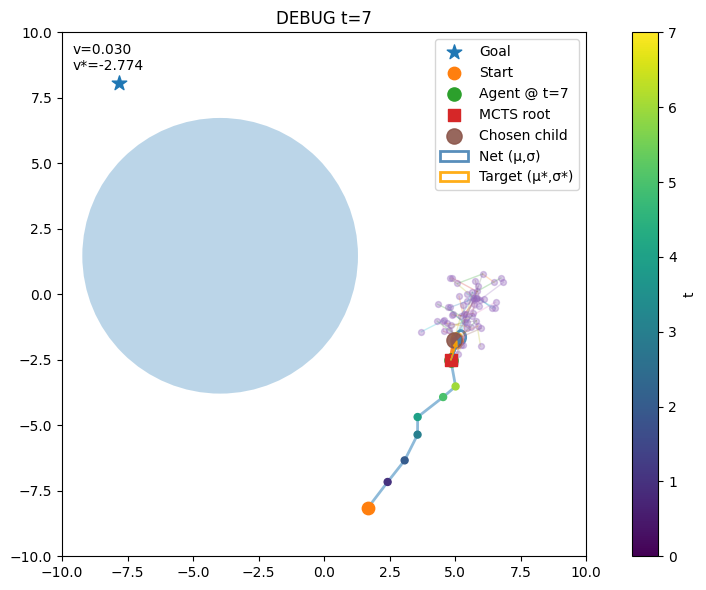

network: (array([0.38624132, 0.8783474 ], dtype=float32), array([-1.7110686, -1.3782288], dtype=float32), 0.02965511381626129)
target: (array([0.23585774, 0.7420298 ], dtype=float32), array([-1.587188 , -1.2760088], dtype=float32), -2.7743985610023367)


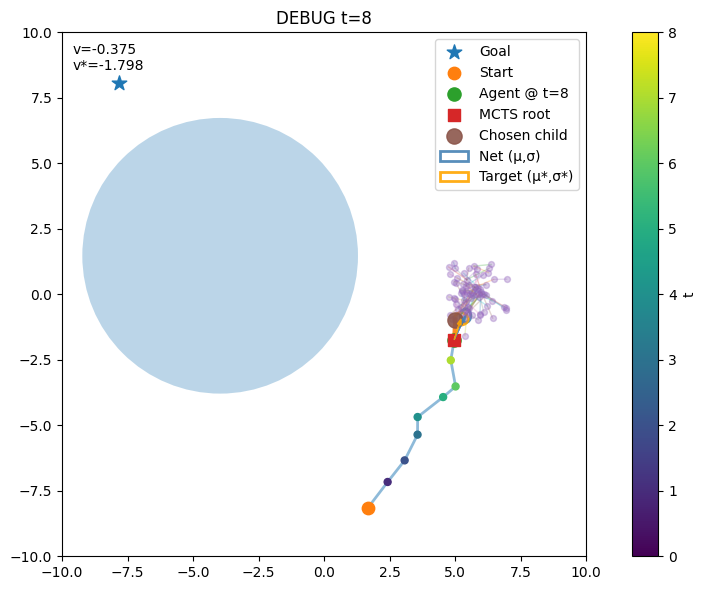

network: (array([0.42910695, 0.90683424], dtype=float32), array([-1.5879633, -1.3589029], dtype=float32), -0.37486588954925537)
target: (array([0.26035538, 0.78778785], dtype=float32), array([-1.3122371, -1.4601811], dtype=float32), -1.7982167952222017)


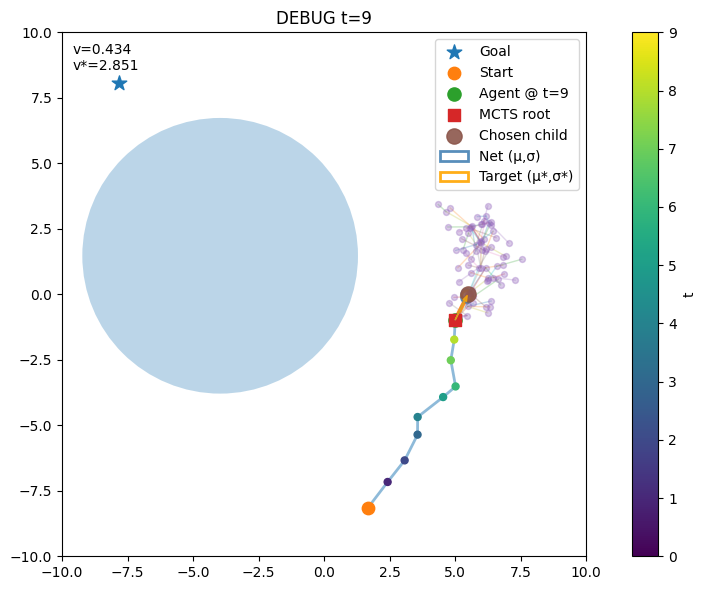

network: (array([0.4416815 , 0.90305436], dtype=float32), array([-1.5663092, -1.3507497], dtype=float32), 0.43358099460601807)
target: (array([0.46325168, 0.9368807 ], dtype=float32), array([-1.5489578, -1.7334889], dtype=float32), 2.851011864750947)


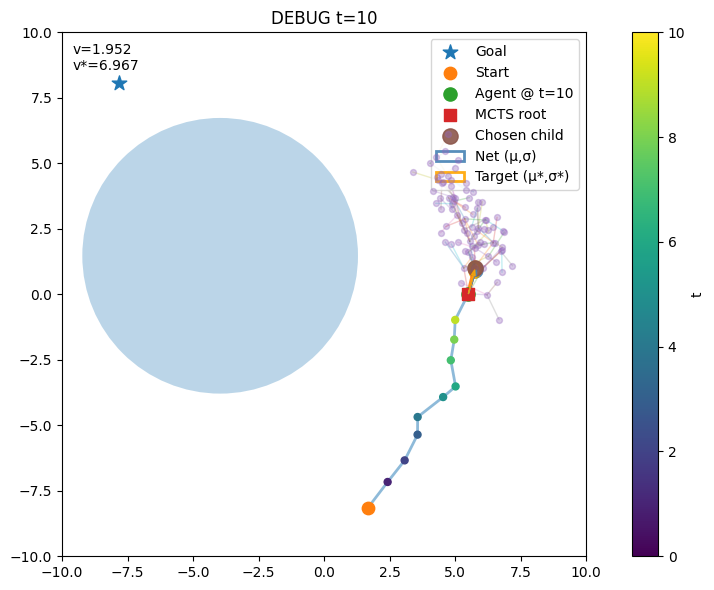

network: (array([0.30906284, 0.9052377 ], dtype=float32), array([-1.5019703, -1.3274362], dtype=float32), 1.9518934488296509)
target: (array([0.24333964, 0.91651016], dtype=float32), array([-1.6086808, -1.1882913], dtype=float32), 6.966732379565715)


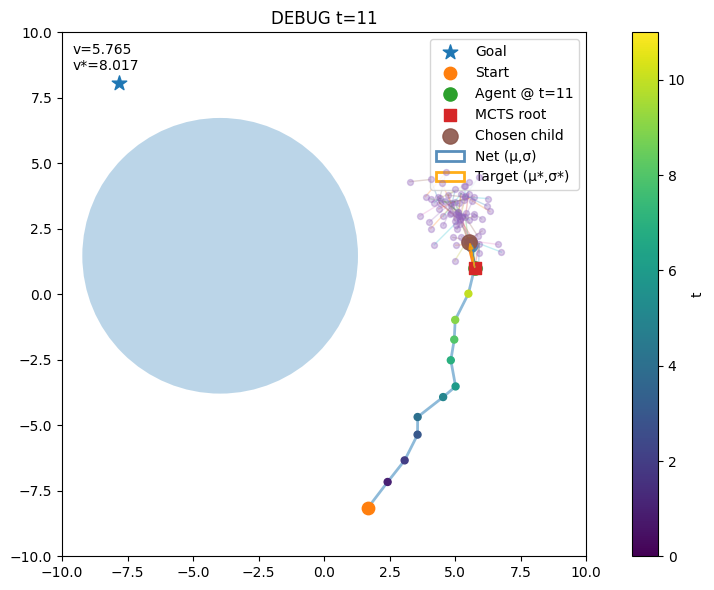

network: (array([-0.10313546,  0.86115897], dtype=float32), array([-1.6088538, -1.3934432], dtype=float32), 5.764729022979736)
target: (array([-0.18512644,  0.9206709 ], dtype=float32), array([-1.7855442, -1.5866328], dtype=float32), 8.016956389393307)


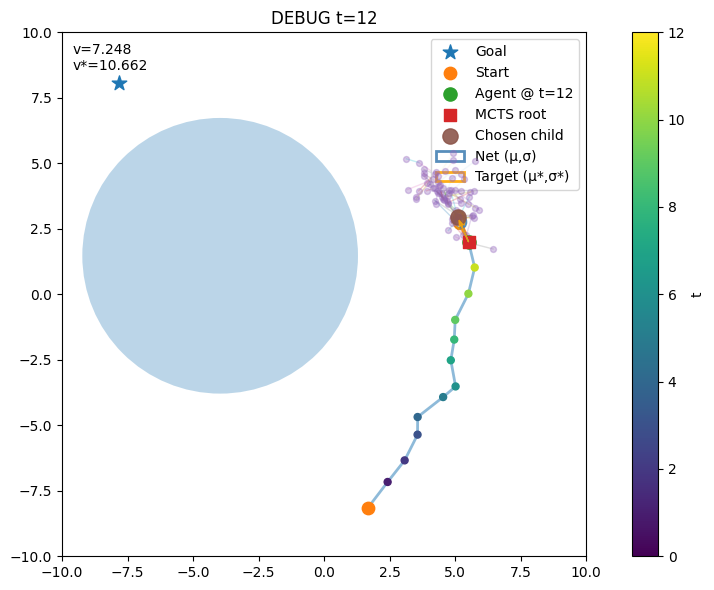

network: (array([-0.31721413,  0.7512437 ], dtype=float32), array([-1.5256019, -1.4160814], dtype=float32), 7.247517108917236)
target: (array([-0.3648383 ,  0.82477856], dtype=float32), array([-1.6324271, -1.1370236], dtype=float32), 10.662052553042205)


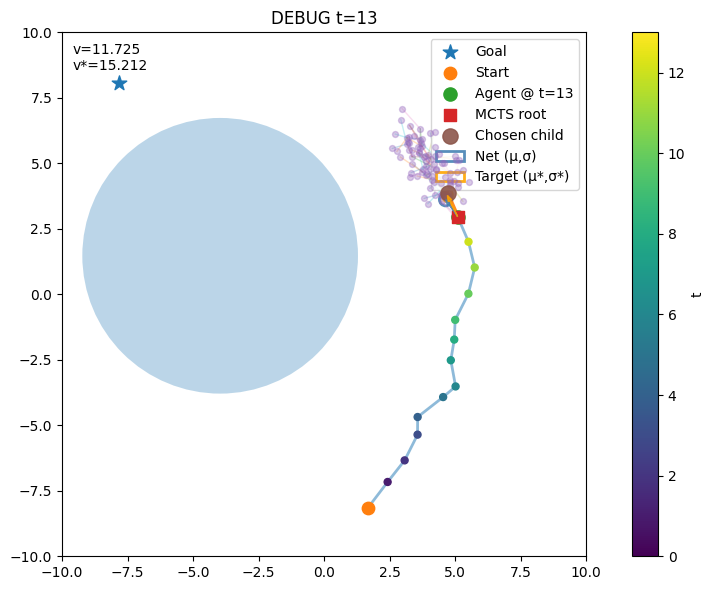

network: (array([-0.45333076,  0.6468971 ], dtype=float32), array([-1.4324329, -1.4200209], dtype=float32), 11.725364685058594)
target: (array([-0.38752404,  0.8079487 ], dtype=float32), array([-1.6603872, -1.4087775], dtype=float32), 15.211688840046422)


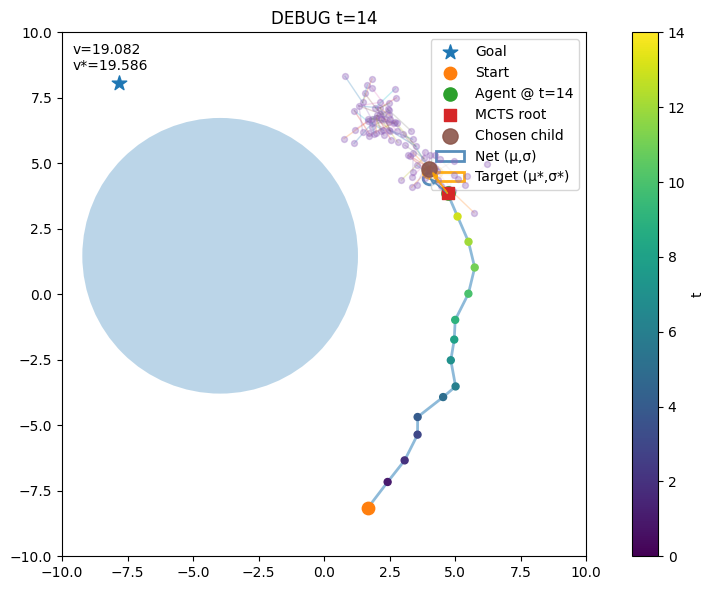

network: (array([-0.6601465,  0.5553081], dtype=float32), array([-1.3112154, -1.4767058], dtype=float32), 19.08222198486328)
target: (array([-0.56805587,  0.7921702 ], dtype=float32), array([-1.0141008, -1.4494461], dtype=float32), 19.585840961050458)


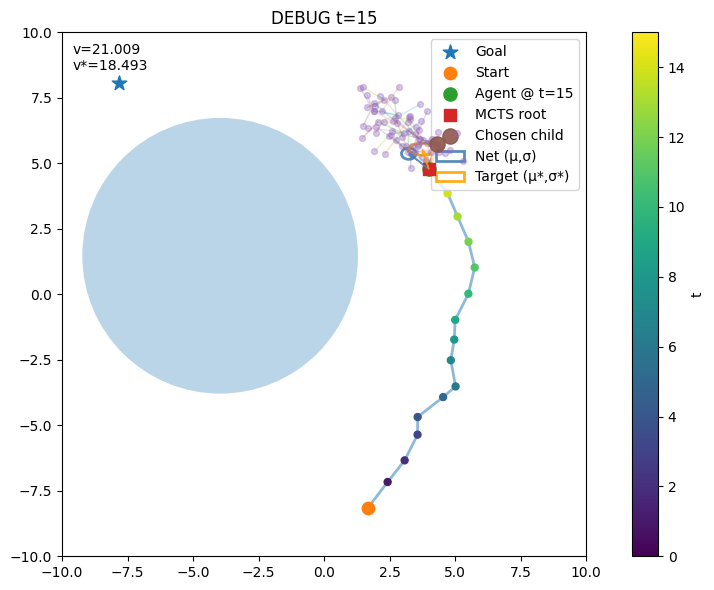

network: (array([-0.764874  ,  0.58991444], dtype=float32), array([-1.2747717, -1.5301573], dtype=float32), 21.008525848388672)
target: (array([-0.24097036,  0.75966185], dtype=float32), array([-0.64634705, -1.4876658 ], dtype=float32), 18.492694515900126)


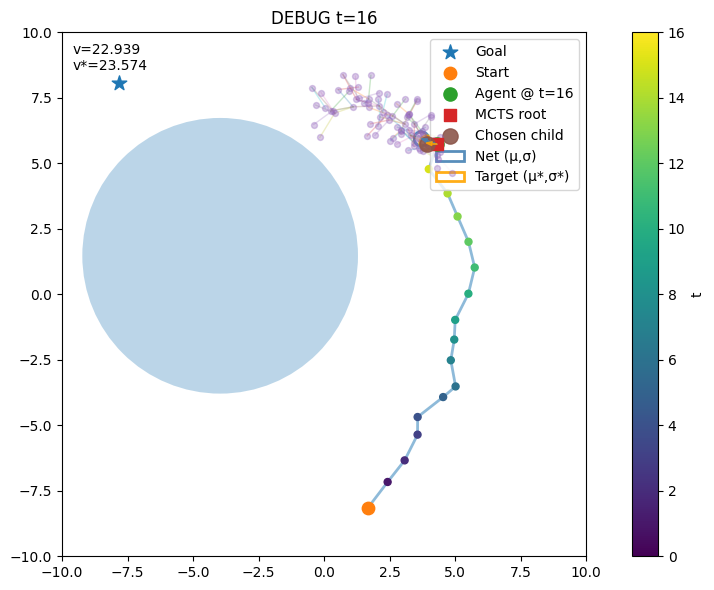

network: (array([-0.6025578 ,  0.20948696], dtype=float32), array([-1.2882661, -1.3185701], dtype=float32), 22.9388427734375)
target: (array([-0.4191957 ,  0.04917805], dtype=float32), array([-1.4248539, -1.3247566], dtype=float32), 23.574484753989285)


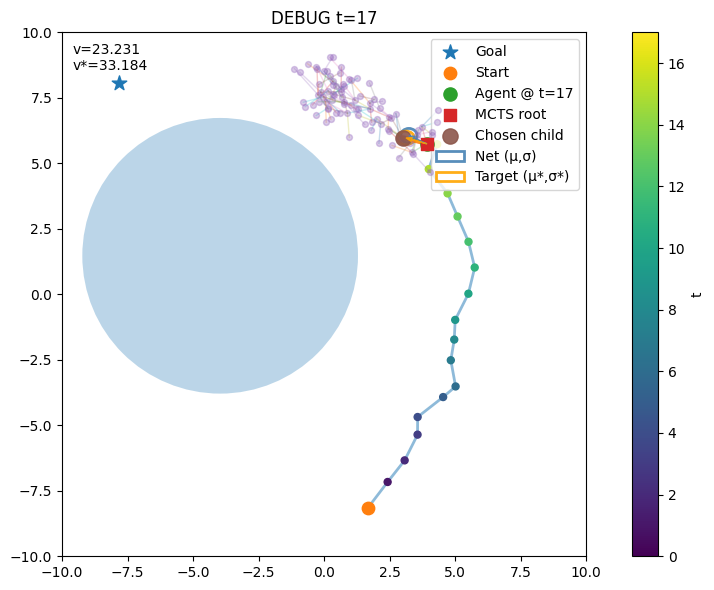

network: (array([-0.68206626,  0.3036852 ], dtype=float32), array([-1.1527997, -1.2674668], dtype=float32), 23.23103141784668)
target: (array([-0.79124415,  0.22281367], dtype=float32), array([-1.1614137, -1.349565 ], dtype=float32), 33.18418442688584)


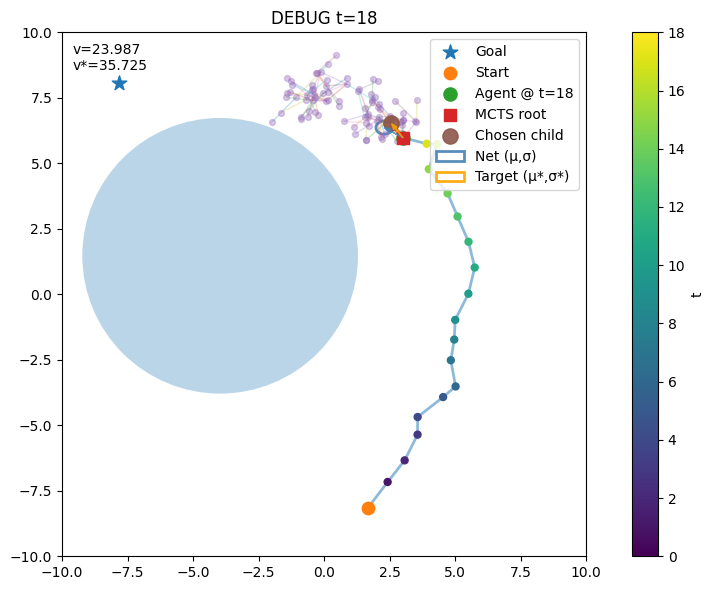

network: (array([-0.71378493,  0.38563287], dtype=float32), array([-1.1513944, -1.3729608], dtype=float32), 23.986780166625977)
target: (array([-0.43341485,  0.53630316], dtype=float32), array([-1.2340288, -1.8263245], dtype=float32), 35.724770202907884)


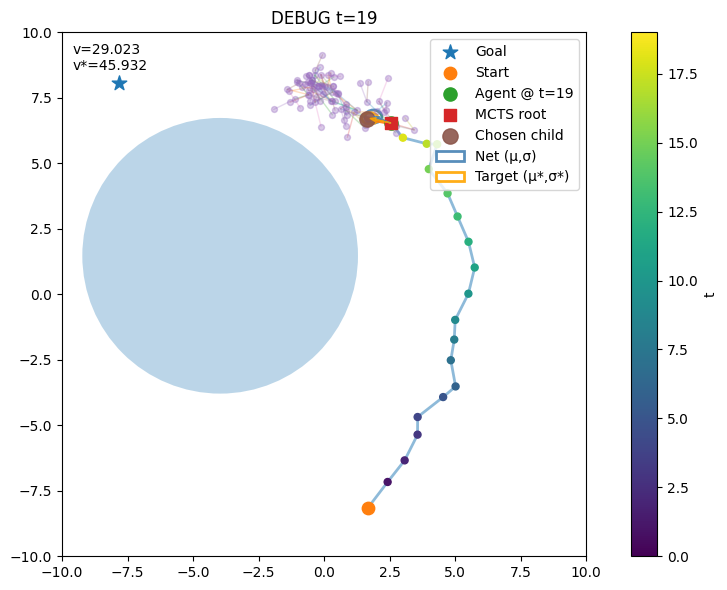

network: (array([-0.6602579 ,  0.24558091], dtype=float32), array([-1.1464125, -1.3850895], dtype=float32), 29.02320671081543)
target: (array([-0.7939923,  0.1741678], dtype=float32), array([-1.1510326, -1.5522281], dtype=float32), 45.93219455080579)


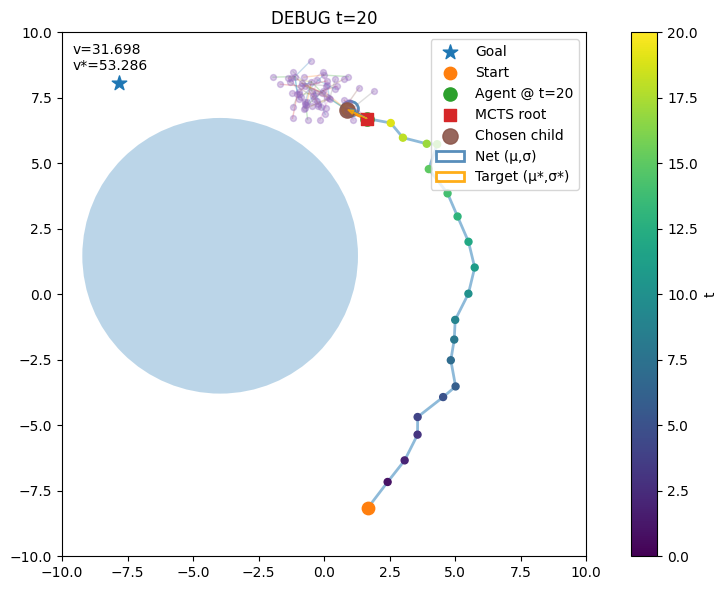

network: (array([-0.63973033,  0.3669626 ], dtype=float32), array([-1.153044 , -1.2489295], dtype=float32), 31.698060989379883)
target: (array([-0.7310138 ,  0.33366367], dtype=float32), array([-1.6121054, -1.7356673], dtype=float32), 53.28551493592464)


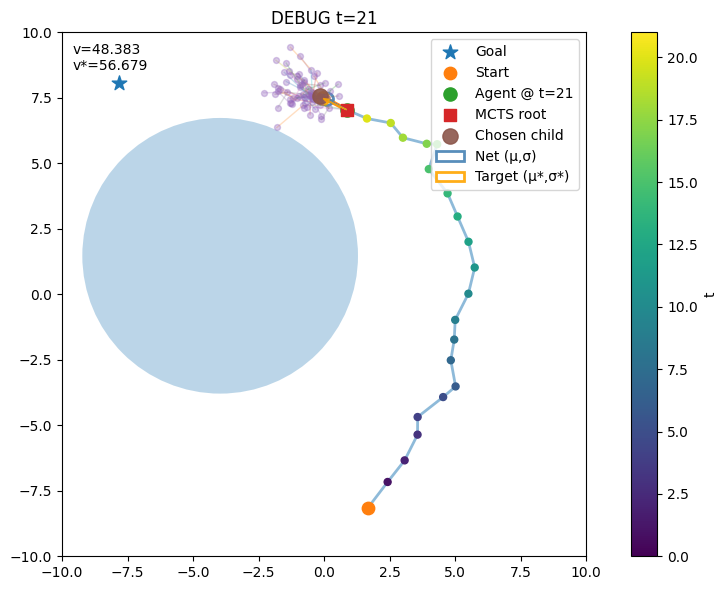

network: (array([-0.731083  ,  0.39694387], dtype=float32), array([-1.4555869, -1.4607644], dtype=float32), 48.38301086425781)
target: (array([-0.8916921 ,  0.42558998], dtype=float32), array([-1.4895542, -1.4649966], dtype=float32), 56.6789210828786)


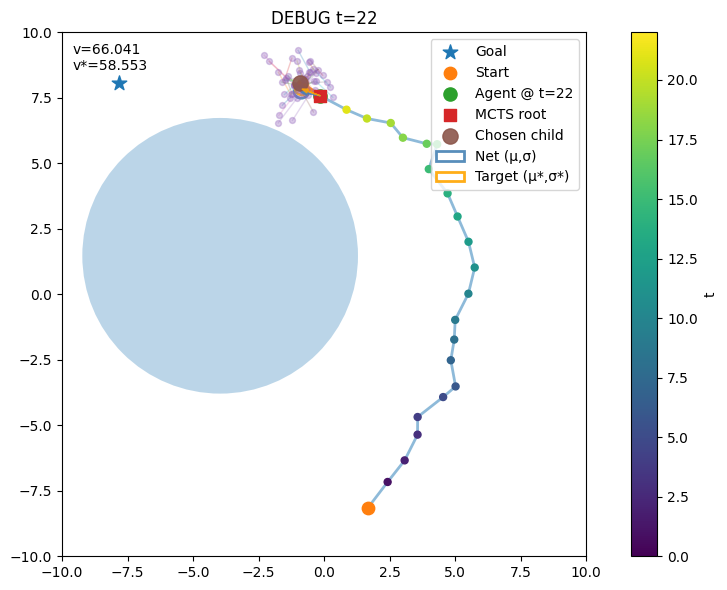

network: (array([-0.7308003 ,  0.14019996], dtype=float32), array([-1.3093431, -1.461108 ], dtype=float32), 66.04132843017578)
target: (array([-0.7033132 ,  0.26055256], dtype=float32), array([-1.3939227, -1.4874505], dtype=float32), 58.5529661168751)


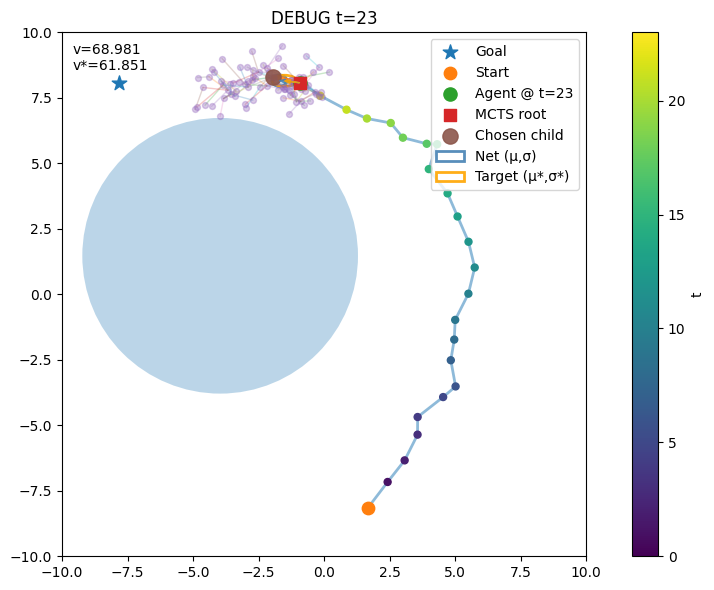

network: (array([-0.770049  ,  0.07880852], dtype=float32), array([-1.2582775, -1.5190468], dtype=float32), 68.98052215576172)
target: (array([-0.5761221,  0.0733213], dtype=float32), array([-0.7795161, -1.5485146], dtype=float32), 61.85111813590405)


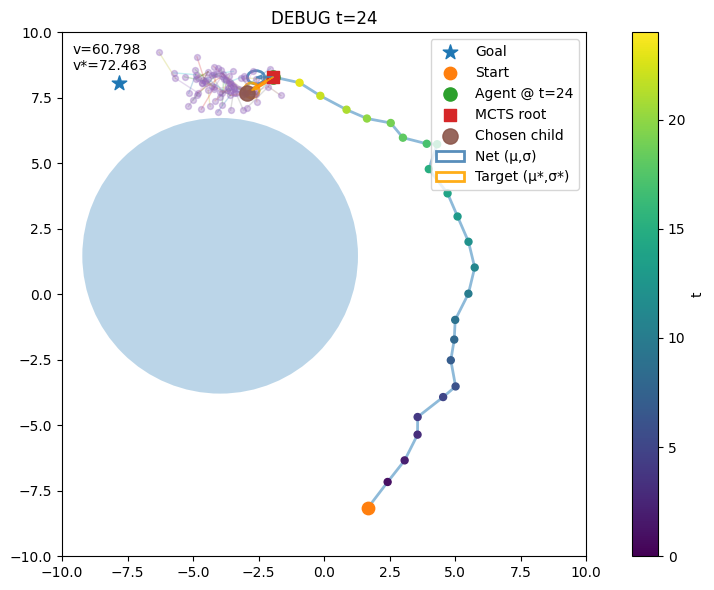

network: (array([-0.6616751 , -0.01226056], dtype=float32), array([-1.1120216, -1.3773901], dtype=float32), 60.79774475097656)
target: (array([-0.8294071, -0.510138 ], dtype=float32), array([-1.2580492, -1.2594322], dtype=float32), 72.46334567594789)


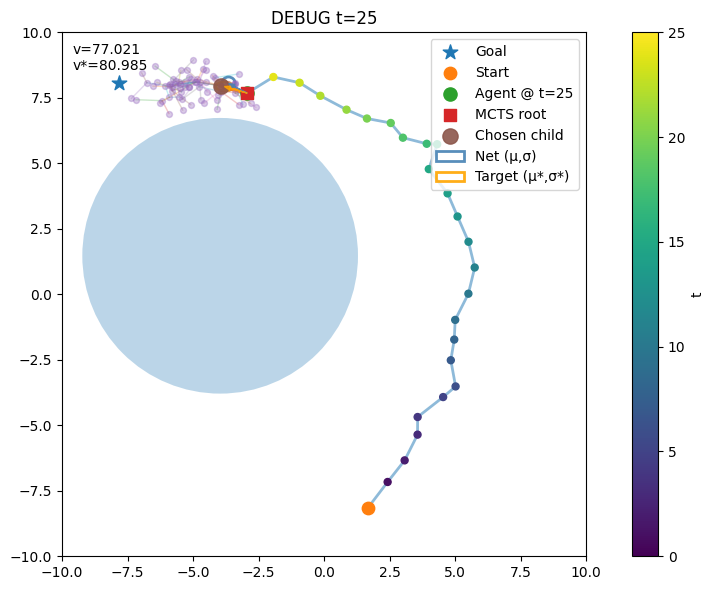

network: (array([-0.71143484,  0.3636772 ], dtype=float32), array([-1.3622907, -1.3823231], dtype=float32), 77.02118682861328)
target: (array([-0.8705636,  0.2511865], dtype=float32), array([-1.1180755, -1.7888823], dtype=float32), 80.98493177385862)


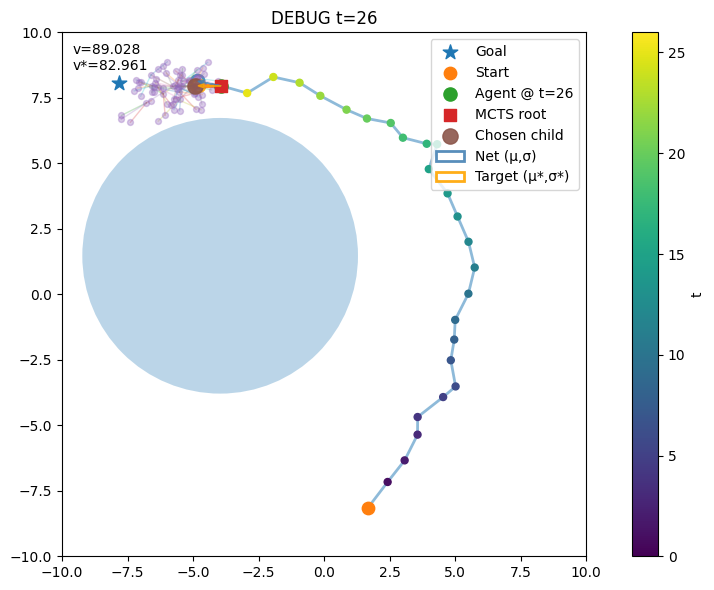

network: (array([-0.88270295,  0.17365876], dtype=float32), array([-1.4277241, -1.438687 ], dtype=float32), 89.0279541015625)
target: (array([-8.778305e-01, -4.989591e-04], dtype=float32), array([-1.3124777, -1.411767 ], dtype=float32), 82.96121406992211)


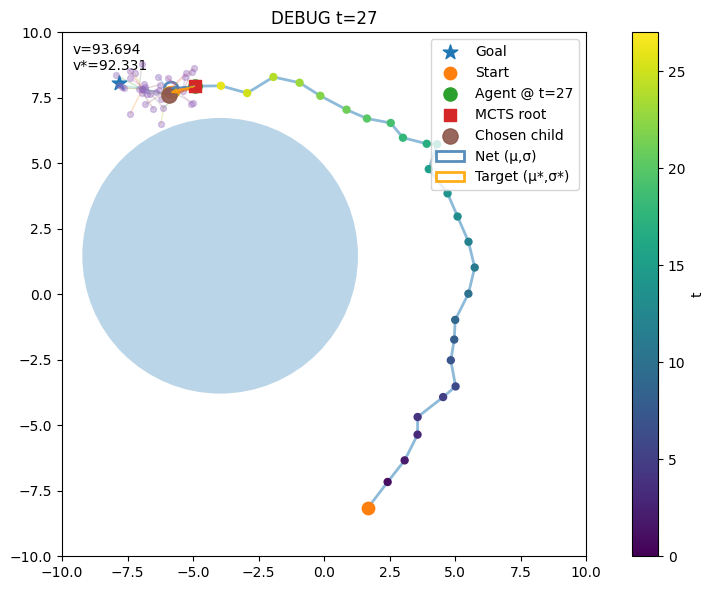

network: (array([-0.9014919 , -0.07820009], dtype=float32), array([-1.3445596, -1.4554437], dtype=float32), 93.69398498535156)
target: (array([-0.89673525, -0.23550862], dtype=float32), array([-1.2441127, -1.6326214], dtype=float32), 92.3312689448094)


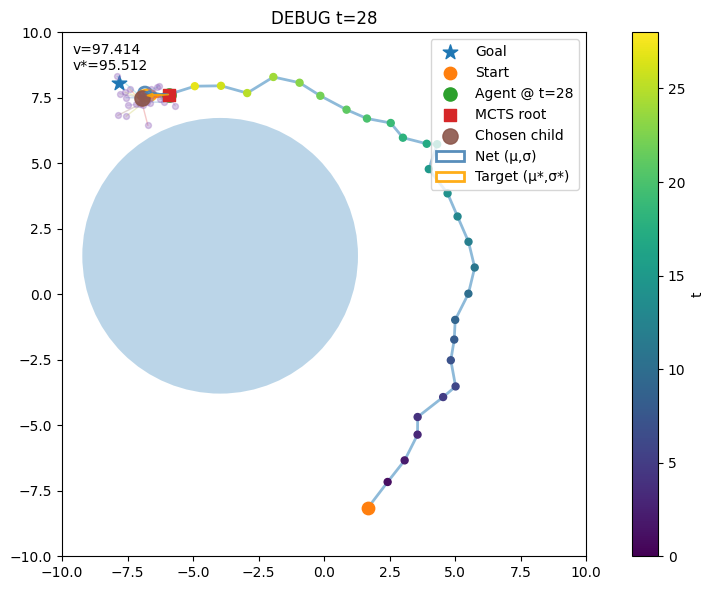

network: (array([-0.90209556,  0.08637225], dtype=float32), array([-1.4699934, -1.620339 ], dtype=float32), 97.41368865966797)
target: (array([-0.82568055, -0.04076474], dtype=float32), array([-1.0769581, -1.5655493], dtype=float32), 95.51227085907524)


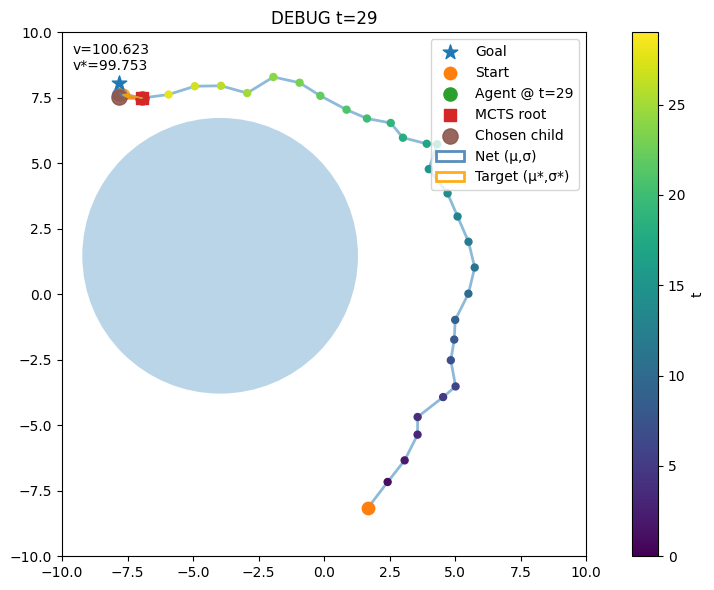

network: (array([-0.86752343,  0.12957305], dtype=float32), array([-1.4067593, -1.5707991], dtype=float32), 100.62291717529297)
target: (array([-0.7588647 ,  0.12046701], dtype=float32), array([-1.4218471, -1.6031586], dtype=float32), 99.75346938852823)


In [54]:
n = len(dbg["roots"])

for i in range(n):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
    plot_dbg_step(dbg, i, ax=ax, max_depth=99, top_k_per_node=4, title=f"DEBUG t={i}")
    plt.tight_layout()
    plt.show()
    print("network:", dbg["network_outputs"][i])
    print("target:", dbg["targets_from_root"][i])

In [55]:
print("---")

---
